### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
result_filename = 'model-02-build-keras-search-batch_size'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 5709.20035 'divorce_rate' 3.333296666667593]
 [1 5709.200316666666 'I_250' 3.333263333333889]
 [2 5708.200346666667 'XI_100' 2.33329333333495]
 [3 5707.867050000001 'VI_index_500' 1.9999966666682667]
 [4 5707.86704 'IX_index_50' 1.9999866666676098]
 [5 5707.866983333333 'VI_500' 1.9999300000008589]
 [6 5707.533710000001 'XIV_10' 1.666656666668132]
 [7 5707.200386666666 'XI_index_500' 1.3333333333339397]
 [8 5707.200383333334 'VI_index_1000' 1.3333300000012969]
 [9 5707.200373333333 'V_100' 1.33332000000064]
 [10 5707.200363333334 'VII_10' 1.333310000001802]
 [11 5707.200336666666 'X_100' 1.3332833333333838]
 [12 5706.867056666667 'XII_index_50' 1.0000033333344618]
 [15 5706.867050000001 'X_index_500' 0.9999966666682667]
 [14 5706.867050000001 'X_10' 0.9999966666682667]
 [13 5706.867050000001 'II_10' 0.9999966666682667]
 [16 5706.867046666666 'II_index_500' 0.9999933333338049]
 [17 5706.867046666666 'V_index_1000' 0.9999933333338049]
 [18 5706.867043333335 'XIII_10' 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
#cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.check()

building_id building_material city txn_dt total_floor  \
0      e3mMIMR3JJqCaXz1                 8   21  18674           4   
1      LgwzgklNvy4QCtq5                 8    7  18800           5   
2      ucIR2NLLsC3T650L                 8    7  19289           4   
3      jre1pJhcQj91Kdky                 8   21  20385          24   
4      rQpYpY9nRG7X5mmr                 1   21  20657           2   
59995  Oh5Hwr9LrWApC2mr                 1    5  19040           2   
59996  PiOgZqfsDVlTq1zs                 8   13  19706          14   
59997  FQmlgGohzzWuKUzu                 8    7  19901          11   
59998  zjzfMwXhDswdEaI2                 8   13  19975           5   
59999  iN4H6wBMtvJpF0SN                 8    7  20385           5   

      building_type building_use building_complete_dt parking_way  \
0                 3            2                 6271           2   
1                 1            2                 7885           2   
2                 1            2                 6028           2   
3                 0            2                18325           0   
4                 4            2                 6880           2   
59995             4            2                 9193           2   
59996             2            5                17168           0   
59997             0            2                13729           0   
59998             1            2                 7063           2   
59999             1            2                 8310           2   

            parking_area  ... XIV_500 XIV_index_500 XIV_1000 XIV_index_1000  \
0                    NaN  ...      58             1      157              1   
1                    NaN  ...      28             1      115              1   
2                    NaN  ...      78             1      212              1   
3                    NaN  ...      20             1      125              1   
4                    NaN  ...      18             1       47              1   
59995                NaN  ...       9             1       53              1   
59996  3.738411744735565  ...      88             1      316              1   
59997                NaN  ...     113             1      348              1   
59998                NaN  ...      23             1      142              1   
59999                NaN  ...      75             1      249              1   

      XIV_5000 XIV_index_5000 XIV_10000 XIV_index_10000             XIV_MIN  \
0         2483              1      6011               1  34.469802848528126   
1        15872              1     32221               1   40.07357348973039   
2        15760              1     32228               1   54.46208108983661   
3         2568              1      7271               1   99.62896580763416   
4         2587              1      7442               1   124.1312362968124   
59995     1435              1      4611               1  145.27967019169262   
59996     5659              1     22826               1   18.81499793345573   
59997    13252              1     32687               1   94.79959334423607   
59998     5317              1     21087               1   33.10458025153816   
59999    15417              1     32826               1   47.50987600102272   

              total_price  
0       647603.7704719775  
1               3321452.0  
2       9570885.316206373  
3      14215011.127100045  
4       762711.9757135696  
59995   987021.4150420949  
59996  15725223.997450478  
59997   11815402.03862225  
59998   18084995.81999832  
59999    8510295.87633061  

[10 rows x 235 columns]

shape = (60000, 235)


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
df = pre_processing(df, cols_num, cols_cat, cols_bin)

/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if df[c].skew() > 2.2]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'N_50', 'N_1000', 'N_5000', 'N_10000', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_50', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII

### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df):
        df = df.copy()   
        
        # Rare village
        village_counts = df['village'].value_counts()
        rare_village = set(village_counts.index[village_counts <= self.rare_village_threshold])
        df.loc[df['village'].isin(rare_village), 'village'] = np.nan
        town_counts = df['town'].value_counts()
        rare_town = set(town_counts.index[town_counts <= self.rare_town_threshold])
        df.loc[df['town'].isin(rare_town), 'town'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [13]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [14]:
from keras_get_best import GetBest
from keras_SGDRScheduler import SGDRScheduler

In [15]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Compute N of parameters

In [16]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [17]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=9647105, n_inputs=194))

(2180, 2180, 1090, 1090, 545, 545)


### Grid search

In [18]:
# grid search
params_fix = {'epochs': 500,
              'loss': 'mse',
              'batch_norm': True,
              'n_neurons': (2180, 2180, 1090, 1090, 545, 545),
             }

# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {
    'batch_size': [32, 64, 128, 256, 512],
    #'learning_rate': [0.0009, 0.001, 0.0012],
}
N_fold = 3
N_iter = 5
score_low_bound = 0 # if score smaller than this, skip the param set

#### Round 1

In [19]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)

In [20]:
rand_params_set

[{'batch_size': 64},
 {'batch_size': 32},
 {'batch_size': 512},
 {'batch_size': 256},
 {'batch_size': 128}]

In [21]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain].reset_index(drop=True)
    df_val = df.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
    print()

    # random sample - grid search
    rand_params_next = []
    for i_set, params_rand in enumerate(rand_params_set):
        print('---', i_set+1, '/', len(rand_params_set), '---')
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

        hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                         callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')], 
                         batch_size=params['batch_size'], epochs=params['epochs'])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] 
                   for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====


W0705 02:40:41.368416 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 02:40:41.421293 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 02:40:41.422482 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'building_type': 6, 'city': 12, 'town': 196, 'building_use': 11, 'village': 2201, 'parking_way': 4, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'building_type': 4, 'city': 6, 'town': 11, 'building_use': 5, 'village': 16, 'parking_way': 4, 'encoded_latlon': 5}
Total embedding output dims: 56

--- 1 / 5 ---


W0705 02:40:41.673806 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0705 02:40:42.261095 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 02:40:43.461673 140172675516160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 21s - loss: 0.2911 - mean_absolute_error: 0.3642 - val_loss: 0.1161 - val_mean_absolute_error: 0.2588
Epoch 2/500
 - 19s - loss: 0.1270 - mean_absolute_error: 0.2704 - val_loss: 0.1007 - val_mean_absolute_error: 0.2436
Epoch 3/500
 - 19s - loss: 0.1097 - mean_absolute_error: 0.2508 - val_loss: 0.0948 - val_mean_absolute_error: 0.2293
Epoch 4/500
 - 19s - loss: 0.0997 - mean_absolute_error: 0.2393 - val_loss: 0.0775 - val_mean_absolute_error: 0.2050
Epoch 5/500
 - 19s - loss: 0.0951 - mean_absolute_error: 0.2338 - val_loss: 0.0909 - val_mean_absolute_error: 0.2222
Epoch 6/500
 - 20s - loss: 0.0896 - mean_absolute_error: 0.2273 - val_loss: 0.0902 - val_mean_absolute_error: 0.2230
Epoch 7/500
 - 19s - loss: 0.0878 - mean_absolute_error: 0.2245 - val_loss: 0.0775 - val_mean_absolute_error: 0.2060
Epoch 8/500
 - 19s - loss: 0.0863 - mean_absolute_error: 0.2223 - val_loss: 0.0729 - val_mean_absolute_error: 0.2001
Epoch 9/500
 -

 - 19s - loss: 0.0236 - mean_absolute_error: 0.1205 - val_loss: 0.0599 - val_mean_absolute_error: 0.1702
Epoch 71/500
 - 19s - loss: 0.0235 - mean_absolute_error: 0.1192 - val_loss: 0.0600 - val_mean_absolute_error: 0.1697
Epoch 72/500
 - 19s - loss: 0.0254 - mean_absolute_error: 0.1254 - val_loss: 0.0589 - val_mean_absolute_error: 0.1676
Epoch 73/500
 - 19s - loss: 0.0235 - mean_absolute_error: 0.1197 - val_loss: 0.0578 - val_mean_absolute_error: 0.1624
Epoch 74/500
 - 19s - loss: 0.0237 - mean_absolute_error: 0.1208 - val_loss: 0.0551 - val_mean_absolute_error: 0.1599
Epoch 75/500
 - 19s - loss: 0.0209 - mean_absolute_error: 0.1141 - val_loss: 0.0589 - val_mean_absolute_error: 0.1667
Epoch 76/500
 - 19s - loss: 0.0227 - mean_absolute_error: 0.1183 - val_loss: 0.0586 - val_mean_absolute_error: 0.1696
Epoch 77/500
 - 19s - loss: 0.0253 - mean_absolute_error: 0.1237 - val_loss: 0.0570 - val_mean_absolute_error: 0.1654
Epoch 78/500
 - 19s - loss: 0.0215 - mean_absolute_error: 0.1158 - va

Epoch 140/500
 - 19s - loss: 0.0187 - mean_absolute_error: 0.1084 - val_loss: 0.0553 - val_mean_absolute_error: 0.1606
Epoch 141/500
 - 19s - loss: 0.0187 - mean_absolute_error: 0.1082 - val_loss: 0.0562 - val_mean_absolute_error: 0.1644
Epoch 142/500
 - 19s - loss: 0.0176 - mean_absolute_error: 0.1048 - val_loss: 0.0559 - val_mean_absolute_error: 0.1615
Epoch 143/500
 - 19s - loss: 0.0191 - mean_absolute_error: 0.1086 - val_loss: 0.0549 - val_mean_absolute_error: 0.1613
Epoch 144/500
 - 19s - loss: 0.0202 - mean_absolute_error: 0.1129 - val_loss: 0.0550 - val_mean_absolute_error: 0.1602
Epoch 145/500
 - 19s - loss: 0.0198 - mean_absolute_error: 0.1115 - val_loss: 0.0561 - val_mean_absolute_error: 0.1639
Epoch 146/500
 - 19s - loss: 0.0187 - mean_absolute_error: 0.1080 - val_loss: 0.0542 - val_mean_absolute_error: 0.1580
Epoch 147/500
 - 19s - loss: 0.0196 - mean_absolute_error: 0.1128 - val_loss: 0.0553 - val_mean_absolute_error: 0.1612
Epoch 148/500
 - 19s - loss: 0.0182 - mean_absol

Epoch 209/500
 - 19s - loss: 0.0191 - mean_absolute_error: 0.1085 - val_loss: 0.0554 - val_mean_absolute_error: 0.1605
Epoch 210/500
 - 19s - loss: 0.0191 - mean_absolute_error: 0.1089 - val_loss: 0.0579 - val_mean_absolute_error: 0.1623
Epoch 211/500
 - 19s - loss: 0.0171 - mean_absolute_error: 0.1050 - val_loss: 0.0543 - val_mean_absolute_error: 0.1552
Epoch 212/500
 - 19s - loss: 0.0187 - mean_absolute_error: 0.1077 - val_loss: 0.0562 - val_mean_absolute_error: 0.1633
Epoch 213/500
 - 19s - loss: 0.0186 - mean_absolute_error: 0.1083 - val_loss: 0.0551 - val_mean_absolute_error: 0.1554
Epoch 214/500
 - 19s - loss: 0.0180 - mean_absolute_error: 0.1060 - val_loss: 0.0540 - val_mean_absolute_error: 0.1561
Epoch 215/500
 - 19s - loss: 0.0171 - mean_absolute_error: 0.1040 - val_loss: 0.0538 - val_mean_absolute_error: 0.1542
Epoch 216/500
 - 19s - loss: 0.0170 - mean_absolute_error: 0.1014 - val_loss: 0.0572 - val_mean_absolute_error: 0.1621
Epoch 217/500
 - 19s - loss: 0.0183 - mean_absol

Epoch 278/500
 - 19s - loss: 0.0180 - mean_absolute_error: 0.1060 - val_loss: 0.0556 - val_mean_absolute_error: 0.1581
Epoch 279/500
 - 19s - loss: 0.0173 - mean_absolute_error: 0.1036 - val_loss: 0.0535 - val_mean_absolute_error: 0.1550
Epoch 280/500
 - 19s - loss: 0.0172 - mean_absolute_error: 0.1042 - val_loss: 0.0537 - val_mean_absolute_error: 0.1553
Epoch 281/500
 - 19s - loss: 0.0173 - mean_absolute_error: 0.1047 - val_loss: 0.0540 - val_mean_absolute_error: 0.1555
Epoch 282/500
 - 19s - loss: 0.0179 - mean_absolute_error: 0.1050 - val_loss: 0.0557 - val_mean_absolute_error: 0.1613
Epoch 283/500
 - 19s - loss: 0.0191 - mean_absolute_error: 0.1100 - val_loss: 0.0542 - val_mean_absolute_error: 0.1574
Epoch 284/500
 - 19s - loss: 0.0189 - mean_absolute_error: 0.1089 - val_loss: 0.0556 - val_mean_absolute_error: 0.1584
Epoch 285/500
 - 19s - loss: 0.0175 - mean_absolute_error: 0.1065 - val_loss: 0.0562 - val_mean_absolute_error: 0.1621
Epoch 286/500
 - 19s - loss: 0.0175 - mean_absol

Epoch 347/500
 - 19s - loss: 0.0171 - mean_absolute_error: 0.1035 - val_loss: 0.0580 - val_mean_absolute_error: 0.1652
Epoch 348/500
 - 19s - loss: 0.0169 - mean_absolute_error: 0.1028 - val_loss: 0.0575 - val_mean_absolute_error: 0.1632
Epoch 349/500
 - 19s - loss: 0.0183 - mean_absolute_error: 0.1076 - val_loss: 0.0552 - val_mean_absolute_error: 0.1586
Epoch 350/500
 - 19s - loss: 0.0177 - mean_absolute_error: 0.1064 - val_loss: 0.0541 - val_mean_absolute_error: 0.1561
Epoch 351/500
 - 19s - loss: 0.0183 - mean_absolute_error: 0.1061 - val_loss: 0.0543 - val_mean_absolute_error: 0.1557
Epoch 352/500
 - 19s - loss: 0.0166 - mean_absolute_error: 0.1020 - val_loss: 0.0538 - val_mean_absolute_error: 0.1545
Epoch 353/500
 - 19s - loss: 0.0152 - mean_absolute_error: 0.0989 - val_loss: 0.0565 - val_mean_absolute_error: 0.1584
Epoch 354/500
 - 19s - loss: 0.0164 - mean_absolute_error: 0.1007 - val_loss: 0.0543 - val_mean_absolute_error: 0.1569
Epoch 355/500
 - 19s - loss: 0.0166 - mean_absol

Epoch 416/500
 - 19s - loss: 0.0173 - mean_absolute_error: 0.1044 - val_loss: 0.0576 - val_mean_absolute_error: 0.1627
Epoch 417/500
 - 19s - loss: 0.0161 - mean_absolute_error: 0.1005 - val_loss: 0.0556 - val_mean_absolute_error: 0.1575
Epoch 418/500
 - 19s - loss: 0.0163 - mean_absolute_error: 0.1022 - val_loss: 0.0575 - val_mean_absolute_error: 0.1599
Epoch 419/500
 - 19s - loss: 0.0179 - mean_absolute_error: 0.1066 - val_loss: 0.0567 - val_mean_absolute_error: 0.1561
Epoch 420/500
 - 19s - loss: 0.0179 - mean_absolute_error: 0.1079 - val_loss: 0.0587 - val_mean_absolute_error: 0.1644
Epoch 421/500
 - 19s - loss: 0.0178 - mean_absolute_error: 0.1062 - val_loss: 0.0570 - val_mean_absolute_error: 0.1595
Epoch 422/500
 - 19s - loss: 0.0172 - mean_absolute_error: 0.1023 - val_loss: 0.0566 - val_mean_absolute_error: 0.1580
Epoch 423/500
 - 19s - loss: 0.0190 - mean_absolute_error: 0.1099 - val_loss: 0.0575 - val_mean_absolute_error: 0.1618
Epoch 424/500
 - 19s - loss: 0.0173 - mean_absol

Epoch 485/500
 - 19s - loss: 0.0175 - mean_absolute_error: 0.1052 - val_loss: 0.0582 - val_mean_absolute_error: 0.1629
Epoch 486/500
 - 19s - loss: 0.0173 - mean_absolute_error: 0.1040 - val_loss: 0.0542 - val_mean_absolute_error: 0.1545
Epoch 487/500
 - 19s - loss: 0.0149 - mean_absolute_error: 0.0978 - val_loss: 0.0561 - val_mean_absolute_error: 0.1606
Epoch 488/500
 - 19s - loss: 0.0172 - mean_absolute_error: 0.1033 - val_loss: 0.0559 - val_mean_absolute_error: 0.1580
Epoch 489/500
 - 19s - loss: 0.0161 - mean_absolute_error: 0.0995 - val_loss: 0.0555 - val_mean_absolute_error: 0.1585
Epoch 490/500
 - 19s - loss: 0.0167 - mean_absolute_error: 0.1010 - val_loss: 0.0557 - val_mean_absolute_error: 0.1567
Epoch 491/500
 - 19s - loss: 0.0171 - mean_absolute_error: 0.1038 - val_loss: 0.0556 - val_mean_absolute_error: 0.1562
Epoch 492/500
 - 20s - loss: 0.0161 - mean_absolute_error: 0.1016 - val_loss: 0.0548 - val_mean_absolute_error: 0.1577
Epoch 493/500
 - 19s - loss: 0.0153 - mean_absol

Epoch 53/500
 - 38s - loss: 0.0469 - mean_absolute_error: 0.1707 - val_loss: 0.0738 - val_mean_absolute_error: 0.1984
Epoch 54/500
 - 38s - loss: 0.0442 - mean_absolute_error: 0.1653 - val_loss: 0.0683 - val_mean_absolute_error: 0.1902
Epoch 55/500
 - 38s - loss: 0.0446 - mean_absolute_error: 0.1668 - val_loss: 0.0752 - val_mean_absolute_error: 0.2022
Epoch 56/500
 - 38s - loss: 0.0490 - mean_absolute_error: 0.1749 - val_loss: 0.0743 - val_mean_absolute_error: 0.1986
Epoch 57/500
 - 38s - loss: 0.0451 - mean_absolute_error: 0.1668 - val_loss: 0.0755 - val_mean_absolute_error: 0.2026
Epoch 58/500
 - 39s - loss: 0.0427 - mean_absolute_error: 0.1624 - val_loss: 0.0751 - val_mean_absolute_error: 0.2020
Epoch 59/500
 - 38s - loss: 0.0479 - mean_absolute_error: 0.1713 - val_loss: 0.0732 - val_mean_absolute_error: 0.1982
Epoch 60/500
 - 38s - loss: 0.0440 - mean_absolute_error: 0.1663 - val_loss: 0.0713 - val_mean_absolute_error: 0.1949
Epoch 61/500
 - 38s - loss: 0.0431 - mean_absolute_error

Epoch 123/500
 - 38s - loss: 0.0391 - mean_absolute_error: 0.1563 - val_loss: 0.1588 - val_mean_absolute_error: 0.1984
Epoch 124/500
 - 38s - loss: 0.0368 - mean_absolute_error: 0.1519 - val_loss: 0.2122 - val_mean_absolute_error: 0.2155
Epoch 125/500
 - 38s - loss: 0.0353 - mean_absolute_error: 0.1491 - val_loss: 0.2988 - val_mean_absolute_error: 0.2089
Epoch 126/500
 - 38s - loss: 0.0377 - mean_absolute_error: 0.1535 - val_loss: 0.0897 - val_mean_absolute_error: 0.2016
Epoch 127/500
 - 38s - loss: 0.0366 - mean_absolute_error: 0.1508 - val_loss: 0.4794 - val_mean_absolute_error: 0.1973
Epoch 128/500
 - 38s - loss: 0.0376 - mean_absolute_error: 0.1545 - val_loss: 0.1468 - val_mean_absolute_error: 0.1876
Epoch 129/500
 - 38s - loss: 0.0371 - mean_absolute_error: 0.1522 - val_loss: 0.0778 - val_mean_absolute_error: 0.1886
Epoch 130/500
 - 38s - loss: 0.0402 - mean_absolute_error: 0.1584 - val_loss: 0.0727 - val_mean_absolute_error: 0.1928
Epoch 131/500
 - 38s - loss: 0.0356 - mean_absol

Epoch 192/500
 - 38s - loss: 0.0353 - mean_absolute_error: 0.1485 - val_loss: 2.3501 - val_mean_absolute_error: 0.2070
Epoch 193/500
 - 38s - loss: 0.0368 - mean_absolute_error: 0.1543 - val_loss: 0.1375 - val_mean_absolute_error: 0.1973
Epoch 194/500
 - 38s - loss: 0.0361 - mean_absolute_error: 0.1503 - val_loss: 0.0707 - val_mean_absolute_error: 0.1944
Epoch 195/500
 - 38s - loss: 0.0354 - mean_absolute_error: 0.1488 - val_loss: 0.0650 - val_mean_absolute_error: 0.1808
Epoch 196/500
 - 38s - loss: 0.0379 - mean_absolute_error: 0.1532 - val_loss: 0.3290 - val_mean_absolute_error: 0.1974
Epoch 197/500
 - 38s - loss: 0.0381 - mean_absolute_error: 0.1548 - val_loss: 1.9880 - val_mean_absolute_error: 0.2159
Epoch 198/500
 - 38s - loss: 0.0348 - mean_absolute_error: 0.1468 - val_loss: 0.2031 - val_mean_absolute_error: 0.1949
Epoch 199/500
 - 38s - loss: 0.0350 - mean_absolute_error: 0.1488 - val_loss: 0.2101 - val_mean_absolute_error: 0.1929
Epoch 200/500
 - 38s - loss: 0.0353 - mean_absol

Epoch 261/500
 - 38s - loss: 0.0340 - mean_absolute_error: 0.1474 - val_loss: 7.1473 - val_mean_absolute_error: 0.2073
Epoch 262/500
 - 38s - loss: 0.0347 - mean_absolute_error: 0.1480 - val_loss: 431.1396 - val_mean_absolute_error: 0.4582
Epoch 263/500
 - 38s - loss: 0.0367 - mean_absolute_error: 0.1524 - val_loss: 0.1942 - val_mean_absolute_error: 0.1926
Epoch 264/500
 - 38s - loss: 0.0358 - mean_absolute_error: 0.1509 - val_loss: 208.2757 - val_mean_absolute_error: 0.3374
Epoch 265/500
 - 38s - loss: 0.0361 - mean_absolute_error: 0.1510 - val_loss: 2.9590 - val_mean_absolute_error: 0.2011
Epoch 266/500
 - 39s - loss: 0.0347 - mean_absolute_error: 0.1487 - val_loss: 44.0918 - val_mean_absolute_error: 0.2432
Epoch 267/500
 - 38s - loss: 0.0351 - mean_absolute_error: 0.1502 - val_loss: 1234.7412 - val_mean_absolute_error: 0.4756
Epoch 268/500
 - 38s - loss: 0.0347 - mean_absolute_error: 0.1490 - val_loss: 6.6028 - val_mean_absolute_error: 0.2058
Epoch 269/500
 - 38s - loss: 0.0344 - me

Epoch 330/500
 - 38s - loss: 0.0329 - mean_absolute_error: 0.1442 - val_loss: 105.2425 - val_mean_absolute_error: 0.3083
Epoch 331/500
 - 38s - loss: 0.0353 - mean_absolute_error: 0.1500 - val_loss: 0.5170 - val_mean_absolute_error: 0.1940
Epoch 332/500
 - 38s - loss: 0.0329 - mean_absolute_error: 0.1441 - val_loss: 1.6426 - val_mean_absolute_error: 0.1969
Epoch 333/500
 - 38s - loss: 0.0324 - mean_absolute_error: 0.1437 - val_loss: 3.2146 - val_mean_absolute_error: 0.1968
Epoch 334/500
 - 38s - loss: 0.0348 - mean_absolute_error: 0.1480 - val_loss: 0.2070 - val_mean_absolute_error: 0.1841
Epoch 335/500
 - 38s - loss: 0.0335 - mean_absolute_error: 0.1465 - val_loss: 0.1517 - val_mean_absolute_error: 0.1894
Epoch 336/500
 - 38s - loss: 0.0348 - mean_absolute_error: 0.1482 - val_loss: 84.3024 - val_mean_absolute_error: 0.3039
Epoch 337/500
 - 38s - loss: 0.0351 - mean_absolute_error: 0.1487 - val_loss: 545.5948 - val_mean_absolute_error: 0.3432
Epoch 338/500
 - 38s - loss: 0.0333 - mean_

Epoch 398/500
 - 38s - loss: 0.0334 - mean_absolute_error: 0.1460 - val_loss: 282.7444 - val_mean_absolute_error: 0.3788
Epoch 399/500
 - 38s - loss: 0.0335 - mean_absolute_error: 0.1454 - val_loss: 138.6891 - val_mean_absolute_error: 0.3349
Epoch 400/500
 - 38s - loss: 0.0327 - mean_absolute_error: 0.1453 - val_loss: 2288932.3415 - val_mean_absolute_error: 31.1653
Epoch 401/500
 - 38s - loss: 0.0341 - mean_absolute_error: 0.1467 - val_loss: 47001596.3624 - val_mean_absolute_error: 66.7403
Epoch 402/500
 - 38s - loss: 0.0327 - mean_absolute_error: 0.1440 - val_loss: 4211953639.5425 - val_mean_absolute_error: 1023.4151
Epoch 403/500
 - 38s - loss: 0.0307 - mean_absolute_error: 0.1382 - val_loss: 27072.9344 - val_mean_absolute_error: 2.1650
Epoch 404/500
 - 38s - loss: 0.0341 - mean_absolute_error: 0.1489 - val_loss: 258159.3163 - val_mean_absolute_error: 5.6217
Epoch 405/500
 - 38s - loss: 0.0337 - mean_absolute_error: 0.1455 - val_loss: 1415679208.9790 - val_mean_absolute_error: 511.93

Epoch 464/500
 - 38s - loss: 0.0337 - mean_absolute_error: 0.1453 - val_loss: 8467.7318 - val_mean_absolute_error: 1.3349
Epoch 465/500
 - 38s - loss: 0.0332 - mean_absolute_error: 0.1450 - val_loss: 3136041528.2824 - val_mean_absolute_error: 553.3437
Epoch 466/500
 - 38s - loss: 0.0315 - mean_absolute_error: 0.1410 - val_loss: 176312.5649 - val_mean_absolute_error: 6.7087
Epoch 467/500
 - 38s - loss: 0.0333 - mean_absolute_error: 0.1447 - val_loss: 694259.7811 - val_mean_absolute_error: 10.4022
Epoch 468/500
 - 38s - loss: 0.0336 - mean_absolute_error: 0.1476 - val_loss: 6786.1925 - val_mean_absolute_error: 1.1153
Epoch 469/500
 - 38s - loss: 0.0346 - mean_absolute_error: 0.1493 - val_loss: 846063.9361 - val_mean_absolute_error: 11.0851
Epoch 470/500
 - 38s - loss: 0.0329 - mean_absolute_error: 0.1439 - val_loss: 4574388.1083 - val_mean_absolute_error: 33.7111
Epoch 471/500
 - 38s - loss: 0.0322 - mean_absolute_error: 0.1433 - val_loss: 2775707.9488 - val_mean_absolute_error: 27.4845


 - 4s - loss: 0.0228 - mean_absolute_error: 0.1137 - val_loss: 0.0672 - val_mean_absolute_error: 0.1870
Epoch 30/500
 - 4s - loss: 0.0252 - mean_absolute_error: 0.1191 - val_loss: 0.0943 - val_mean_absolute_error: 0.2252
Epoch 31/500
 - 4s - loss: 0.0218 - mean_absolute_error: 0.1123 - val_loss: 0.0690 - val_mean_absolute_error: 0.1937
Epoch 32/500
 - 4s - loss: 0.0223 - mean_absolute_error: 0.1132 - val_loss: 0.0700 - val_mean_absolute_error: 0.1927
Epoch 33/500
 - 4s - loss: 0.0239 - mean_absolute_error: 0.1174 - val_loss: 0.0742 - val_mean_absolute_error: 0.2039
Epoch 34/500
 - 4s - loss: 0.0206 - mean_absolute_error: 0.1102 - val_loss: 0.0683 - val_mean_absolute_error: 0.1846
Epoch 35/500
 - 4s - loss: 0.0185 - mean_absolute_error: 0.1033 - val_loss: 0.0704 - val_mean_absolute_error: 0.1940
Epoch 36/500
 - 4s - loss: 0.0231 - mean_absolute_error: 0.1153 - val_loss: 0.1064 - val_mean_absolute_error: 0.2450
Epoch 37/500
 - 4s - loss: 0.0216 - mean_absolute_error: 0.1103 - val_loss: 0

Epoch 100/500
 - 4s - loss: 0.0134 - mean_absolute_error: 0.0887 - val_loss: 0.0601 - val_mean_absolute_error: 0.1721
Epoch 101/500
 - 4s - loss: 0.0154 - mean_absolute_error: 0.0922 - val_loss: 0.0652 - val_mean_absolute_error: 0.1765
Epoch 102/500
 - 4s - loss: 0.0150 - mean_absolute_error: 0.0925 - val_loss: 0.0677 - val_mean_absolute_error: 0.1841
Epoch 103/500
 - 4s - loss: 0.0153 - mean_absolute_error: 0.0930 - val_loss: 0.0625 - val_mean_absolute_error: 0.1739
Epoch 104/500
 - 4s - loss: 0.0141 - mean_absolute_error: 0.0897 - val_loss: 0.0795 - val_mean_absolute_error: 0.1971
Epoch 105/500
 - 4s - loss: 0.0127 - mean_absolute_error: 0.0841 - val_loss: 0.0594 - val_mean_absolute_error: 0.1676
Epoch 106/500
 - 4s - loss: 0.0146 - mean_absolute_error: 0.0917 - val_loss: 0.0679 - val_mean_absolute_error: 0.1824
Epoch 107/500
 - 4s - loss: 0.0134 - mean_absolute_error: 0.0882 - val_loss: 0.0680 - val_mean_absolute_error: 0.1803
Epoch 108/500
 - 4s - loss: 0.0135 - mean_absolute_error

Epoch 170/500
 - 4s - loss: 0.0081 - mean_absolute_error: 0.0674 - val_loss: 0.0666 - val_mean_absolute_error: 0.1806
Epoch 171/500
 - 4s - loss: 0.0081 - mean_absolute_error: 0.0663 - val_loss: 0.0566 - val_mean_absolute_error: 0.1638
Epoch 172/500
 - 4s - loss: 0.0083 - mean_absolute_error: 0.0686 - val_loss: 0.0643 - val_mean_absolute_error: 0.1770
Epoch 173/500
 - 4s - loss: 0.0071 - mean_absolute_error: 0.0626 - val_loss: 0.0565 - val_mean_absolute_error: 0.1630
Epoch 174/500
 - 4s - loss: 0.0083 - mean_absolute_error: 0.0683 - val_loss: 0.0592 - val_mean_absolute_error: 0.1669
Epoch 175/500
 - 4s - loss: 0.0075 - mean_absolute_error: 0.0629 - val_loss: 0.0612 - val_mean_absolute_error: 0.1715
Epoch 176/500
 - 4s - loss: 0.0076 - mean_absolute_error: 0.0653 - val_loss: 0.0631 - val_mean_absolute_error: 0.1704
Epoch 177/500
 - 4s - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0548 - val_mean_absolute_error: 0.1605
Epoch 178/500
 - 4s - loss: 0.0097 - mean_absolute_error

Epoch 240/500
 - 4s - loss: 0.0056 - mean_absolute_error: 0.0554 - val_loss: 0.0563 - val_mean_absolute_error: 0.1604
Epoch 241/500
 - 4s - loss: 0.0073 - mean_absolute_error: 0.0624 - val_loss: 0.0611 - val_mean_absolute_error: 0.1717
Epoch 242/500
 - 4s - loss: 0.0076 - mean_absolute_error: 0.0642 - val_loss: 0.0549 - val_mean_absolute_error: 0.1579
Epoch 243/500
 - 4s - loss: 0.0073 - mean_absolute_error: 0.0638 - val_loss: 0.0636 - val_mean_absolute_error: 0.1756
Epoch 244/500
 - 4s - loss: 0.0062 - mean_absolute_error: 0.0584 - val_loss: 0.0522 - val_mean_absolute_error: 0.1526
Epoch 245/500
 - 4s - loss: 0.0057 - mean_absolute_error: 0.0569 - val_loss: 0.0547 - val_mean_absolute_error: 0.1580
Epoch 246/500
 - 4s - loss: 0.0069 - mean_absolute_error: 0.0616 - val_loss: 0.0521 - val_mean_absolute_error: 0.1525
Epoch 247/500
 - 4s - loss: 0.0051 - mean_absolute_error: 0.0535 - val_loss: 0.0588 - val_mean_absolute_error: 0.1634
Epoch 248/500
 - 4s - loss: 0.0061 - mean_absolute_error

Epoch 310/500
 - 4s - loss: 0.0046 - mean_absolute_error: 0.0508 - val_loss: 0.0519 - val_mean_absolute_error: 0.1512
Epoch 311/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0555 - val_mean_absolute_error: 0.1591
Epoch 312/500
 - 4s - loss: 0.0053 - mean_absolute_error: 0.0547 - val_loss: 0.0544 - val_mean_absolute_error: 0.1564
Epoch 313/500
 - 4s - loss: 0.0050 - mean_absolute_error: 0.0508 - val_loss: 0.0524 - val_mean_absolute_error: 0.1520
Epoch 314/500
 - 4s - loss: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0524 - val_mean_absolute_error: 0.1525
Epoch 315/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0528 - val_mean_absolute_error: 0.1531
Epoch 316/500
 - 4s - loss: 0.0054 - mean_absolute_error: 0.0554 - val_loss: 0.0523 - val_mean_absolute_error: 0.1527
Epoch 317/500
 - 4s - loss: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0517 - val_mean_absolute_error: 0.1515
Epoch 318/500
 - 4s - loss: 0.0048 - mean_absolute_error

Epoch 380/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0518 - val_mean_absolute_error: 0.1503
Epoch 381/500
 - 4s - loss: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0530 - val_mean_absolute_error: 0.1527
Epoch 382/500
 - 4s - loss: 0.0043 - mean_absolute_error: 0.0493 - val_loss: 0.0525 - val_mean_absolute_error: 0.1507
Epoch 383/500
 - 4s - loss: 0.0038 - mean_absolute_error: 0.0453 - val_loss: 0.0549 - val_mean_absolute_error: 0.1559
Epoch 384/500
 - 4s - loss: 0.0060 - mean_absolute_error: 0.0566 - val_loss: 0.0548 - val_mean_absolute_error: 0.1558
Epoch 385/500
 - 4s - loss: 0.0057 - mean_absolute_error: 0.0556 - val_loss: 0.0524 - val_mean_absolute_error: 0.1524
Epoch 386/500
 - 4s - loss: 0.0050 - mean_absolute_error: 0.0526 - val_loss: 0.0525 - val_mean_absolute_error: 0.1516
Epoch 387/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0507 - val_loss: 0.0523 - val_mean_absolute_error: 0.1511
Epoch 388/500
 - 4s - loss: 0.0043 - mean_absolute_error

Epoch 450/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0512 - val_mean_absolute_error: 0.1485
Epoch 451/500
 - 4s - loss: 0.0033 - mean_absolute_error: 0.0438 - val_loss: 0.0522 - val_mean_absolute_error: 0.1505
Epoch 452/500
 - 4s - loss: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0517 - val_mean_absolute_error: 0.1494
Epoch 453/500
 - 4s - loss: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0533 - val_mean_absolute_error: 0.1524
Epoch 454/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0516 - val_mean_absolute_error: 0.1498
Epoch 455/500
 - 4s - loss: 0.0028 - mean_absolute_error: 0.0395 - val_loss: 0.0516 - val_mean_absolute_error: 0.1491
Epoch 456/500
 - 4s - loss: 0.0028 - mean_absolute_error: 0.0401 - val_loss: 0.0519 - val_mean_absolute_error: 0.1505
Epoch 457/500
 - 4s - loss: 0.0031 - mean_absolute_error: 0.0429 - val_loss: 0.0528 - val_mean_absolute_error: 0.1528
Epoch 458/500
 - 4s - loss: 0.0033 - mean_absolute_error

Epoch 18/500
 - 6s - loss: 0.0384 - mean_absolute_error: 0.1490 - val_loss: 0.0633 - val_mean_absolute_error: 0.1816
Epoch 19/500
 - 6s - loss: 0.0373 - mean_absolute_error: 0.1467 - val_loss: 0.1104 - val_mean_absolute_error: 0.2428
Epoch 20/500
 - 6s - loss: 0.0360 - mean_absolute_error: 0.1443 - val_loss: 0.0772 - val_mean_absolute_error: 0.2043
Epoch 21/500
 - 6s - loss: 0.0362 - mean_absolute_error: 0.1454 - val_loss: 0.0611 - val_mean_absolute_error: 0.1759
Epoch 22/500
 - 6s - loss: 0.0322 - mean_absolute_error: 0.1368 - val_loss: 0.0619 - val_mean_absolute_error: 0.1793
Epoch 23/500
 - 6s - loss: 0.0340 - mean_absolute_error: 0.1405 - val_loss: 0.0656 - val_mean_absolute_error: 0.1845
Epoch 24/500
 - 6s - loss: 0.0309 - mean_absolute_error: 0.1337 - val_loss: 0.0630 - val_mean_absolute_error: 0.1801
Epoch 25/500
 - 6s - loss: 0.0310 - mean_absolute_error: 0.1339 - val_loss: 0.0630 - val_mean_absolute_error: 0.1818
Epoch 26/500
 - 6s - loss: 0.0309 - mean_absolute_error: 0.1352 

 - 6s - loss: 0.0148 - mean_absolute_error: 0.0920 - val_loss: 0.0679 - val_mean_absolute_error: 0.1829
Epoch 89/500
 - 6s - loss: 0.0139 - mean_absolute_error: 0.0889 - val_loss: 0.0559 - val_mean_absolute_error: 0.1625
Epoch 90/500
 - 6s - loss: 0.0127 - mean_absolute_error: 0.0853 - val_loss: 0.0567 - val_mean_absolute_error: 0.1626
Epoch 91/500
 - 6s - loss: 0.0138 - mean_absolute_error: 0.0891 - val_loss: 0.0549 - val_mean_absolute_error: 0.1598
Epoch 92/500
 - 6s - loss: 0.0131 - mean_absolute_error: 0.0873 - val_loss: 0.0578 - val_mean_absolute_error: 0.1657
Epoch 93/500
 - 6s - loss: 0.0114 - mean_absolute_error: 0.0811 - val_loss: 0.0601 - val_mean_absolute_error: 0.1713
Epoch 94/500
 - 6s - loss: 0.0148 - mean_absolute_error: 0.0915 - val_loss: 0.0593 - val_mean_absolute_error: 0.1686
Epoch 95/500
 - 6s - loss: 0.0134 - mean_absolute_error: 0.0880 - val_loss: 0.0670 - val_mean_absolute_error: 0.1801
Epoch 96/500
 - 6s - loss: 0.0123 - mean_absolute_error: 0.0844 - val_loss: 0

Epoch 158/500
 - 6s - loss: 0.0075 - mean_absolute_error: 0.0655 - val_loss: 0.0544 - val_mean_absolute_error: 0.1562
Epoch 159/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0621 - val_loss: 0.0534 - val_mean_absolute_error: 0.1548
Epoch 160/500
 - 6s - loss: 0.0071 - mean_absolute_error: 0.0657 - val_loss: 0.0519 - val_mean_absolute_error: 0.1512
Epoch 161/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0622 - val_loss: 0.0538 - val_mean_absolute_error: 0.1556
Epoch 162/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0680 - val_loss: 0.0537 - val_mean_absolute_error: 0.1542
Epoch 163/500
 - 6s - loss: 0.0078 - mean_absolute_error: 0.0686 - val_loss: 0.0526 - val_mean_absolute_error: 0.1539
Epoch 164/500
 - 6s - loss: 0.0074 - mean_absolute_error: 0.0660 - val_loss: 0.0520 - val_mean_absolute_error: 0.1519
Epoch 165/500
 - 6s - loss: 0.0076 - mean_absolute_error: 0.0665 - val_loss: 0.0548 - val_mean_absolute_error: 0.1597
Epoch 166/500
 - 6s - loss: 0.0079 - mean_absolute_error

Epoch 228/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0604 - val_loss: 0.0523 - val_mean_absolute_error: 0.1502
Epoch 229/500
 - 6s - loss: 0.0072 - mean_absolute_error: 0.0664 - val_loss: 0.0527 - val_mean_absolute_error: 0.1515
Epoch 230/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0601 - val_loss: 0.0528 - val_mean_absolute_error: 0.1511
Epoch 231/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0544 - val_loss: 0.0518 - val_mean_absolute_error: 0.1493
Epoch 232/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0590 - val_loss: 0.0532 - val_mean_absolute_error: 0.1524
Epoch 233/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0599 - val_loss: 0.0531 - val_mean_absolute_error: 0.1519
Epoch 234/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0552 - val_loss: 0.0531 - val_mean_absolute_error: 0.1514
Epoch 235/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0572 - val_loss: 0.0535 - val_mean_absolute_error: 0.1530
Epoch 236/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 298/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0519 - val_mean_absolute_error: 0.1486
Epoch 299/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0574 - val_loss: 0.0526 - val_mean_absolute_error: 0.1497
Epoch 300/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0523 - val_mean_absolute_error: 0.1500
Epoch 301/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0584 - val_loss: 0.0524 - val_mean_absolute_error: 0.1510
Epoch 302/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0596 - val_loss: 0.0525 - val_mean_absolute_error: 0.1506
Epoch 303/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0522 - val_mean_absolute_error: 0.1492
Epoch 304/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0524 - val_mean_absolute_error: 0.1495
Epoch 305/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0584 - val_loss: 0.0532 - val_mean_absolute_error: 0.1519
Epoch 306/500
 - 6s - loss: 0.0049 - mean_absolute_error

Epoch 368/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0582 - val_loss: 0.0538 - val_mean_absolute_error: 0.1527
Epoch 369/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0539 - val_mean_absolute_error: 0.1530
Epoch 370/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0595 - val_loss: 0.0528 - val_mean_absolute_error: 0.1500
Epoch 371/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0533 - val_mean_absolute_error: 0.1516
Epoch 372/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0531 - val_mean_absolute_error: 0.1504
Epoch 373/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0527 - val_mean_absolute_error: 0.1502
Epoch 374/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0529 - val_mean_absolute_error: 0.1512
Epoch 375/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0512 - val_loss: 0.0525 - val_mean_absolute_error: 0.1509
Epoch 376/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 438/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0530 - val_mean_absolute_error: 0.1509
Epoch 439/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0528 - val_mean_absolute_error: 0.1500
Epoch 440/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0546 - val_loss: 0.0532 - val_mean_absolute_error: 0.1505
Epoch 441/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0612 - val_loss: 0.0543 - val_mean_absolute_error: 0.1531
Epoch 442/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0543 - val_loss: 0.0543 - val_mean_absolute_error: 0.1520
Epoch 443/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0535 - val_mean_absolute_error: 0.1505
Epoch 444/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0532 - val_mean_absolute_error: 0.1516
Epoch 445/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0531 - val_mean_absolute_error: 0.1499
Epoch 446/500
 - 6s - loss: 0.0046 - mean_absolute_error

Epoch 6/500
 - 11s - loss: 0.0739 - mean_absolute_error: 0.2063 - val_loss: 0.0721 - val_mean_absolute_error: 0.1978
Epoch 7/500
 - 11s - loss: 0.0701 - mean_absolute_error: 0.1996 - val_loss: 0.1026 - val_mean_absolute_error: 0.2495
Epoch 8/500
 - 11s - loss: 0.0691 - mean_absolute_error: 0.1987 - val_loss: 0.0697 - val_mean_absolute_error: 0.1946
Epoch 9/500
 - 11s - loss: 0.0652 - mean_absolute_error: 0.1934 - val_loss: 0.0737 - val_mean_absolute_error: 0.2015
Epoch 10/500
 - 11s - loss: 0.0629 - mean_absolute_error: 0.1901 - val_loss: 0.0811 - val_mean_absolute_error: 0.2102
Epoch 11/500
 - 11s - loss: 0.0606 - mean_absolute_error: 0.1858 - val_loss: 0.0882 - val_mean_absolute_error: 0.2151
Epoch 12/500
 - 10s - loss: 0.0574 - mean_absolute_error: 0.1813 - val_loss: 0.0720 - val_mean_absolute_error: 0.1960
Epoch 13/500
 - 11s - loss: 0.0565 - mean_absolute_error: 0.1805 - val_loss: 0.0655 - val_mean_absolute_error: 0.1870
Epoch 14/500
 - 11s - loss: 0.0564 - mean_absolute_error: 0.

Epoch 76/500
 - 10s - loss: 0.0158 - mean_absolute_error: 0.0967 - val_loss: 0.0573 - val_mean_absolute_error: 0.1643
Epoch 77/500
 - 10s - loss: 0.0152 - mean_absolute_error: 0.0953 - val_loss: 0.0549 - val_mean_absolute_error: 0.1592
Epoch 78/500
 - 10s - loss: 0.0155 - mean_absolute_error: 0.0965 - val_loss: 0.0569 - val_mean_absolute_error: 0.1623
Epoch 79/500
 - 11s - loss: 0.0154 - mean_absolute_error: 0.0955 - val_loss: 0.0552 - val_mean_absolute_error: 0.1605
Epoch 80/500
 - 11s - loss: 0.0158 - mean_absolute_error: 0.0961 - val_loss: 0.0571 - val_mean_absolute_error: 0.1642
Epoch 81/500
 - 11s - loss: 0.0144 - mean_absolute_error: 0.0934 - val_loss: 0.0554 - val_mean_absolute_error: 0.1603
Epoch 82/500
 - 11s - loss: 0.0137 - mean_absolute_error: 0.0904 - val_loss: 0.0553 - val_mean_absolute_error: 0.1602
Epoch 83/500
 - 11s - loss: 0.0153 - mean_absolute_error: 0.0957 - val_loss: 0.0557 - val_mean_absolute_error: 0.1617
Epoch 84/500
 - 11s - loss: 0.0155 - mean_absolute_error

 - 11s - loss: 0.0104 - mean_absolute_error: 0.0783 - val_loss: 0.0534 - val_mean_absolute_error: 0.1547
Epoch 146/500
 - 11s - loss: 0.0102 - mean_absolute_error: 0.0801 - val_loss: 0.0533 - val_mean_absolute_error: 0.1545
Epoch 147/500
 - 11s - loss: 0.0100 - mean_absolute_error: 0.0784 - val_loss: 0.0524 - val_mean_absolute_error: 0.1524
Epoch 148/500
 - 11s - loss: 0.0111 - mean_absolute_error: 0.0821 - val_loss: 0.0564 - val_mean_absolute_error: 0.1571
Epoch 149/500
 - 11s - loss: 0.0112 - mean_absolute_error: 0.0832 - val_loss: 0.0523 - val_mean_absolute_error: 0.1517
Epoch 150/500
 - 11s - loss: 0.0101 - mean_absolute_error: 0.0783 - val_loss: 0.0522 - val_mean_absolute_error: 0.1518
Epoch 151/500
 - 11s - loss: 0.0112 - mean_absolute_error: 0.0836 - val_loss: 0.0530 - val_mean_absolute_error: 0.1535
Epoch 152/500
 - 11s - loss: 0.0115 - mean_absolute_error: 0.0831 - val_loss: 0.0519 - val_mean_absolute_error: 0.1508
Epoch 153/500
 - 11s - loss: 0.0106 - mean_absolute_error: 0.0

Epoch 214/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0758 - val_loss: 0.0530 - val_mean_absolute_error: 0.1520
Epoch 215/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0785 - val_loss: 0.0524 - val_mean_absolute_error: 0.1508
Epoch 216/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0778 - val_loss: 0.0526 - val_mean_absolute_error: 0.1518
Epoch 217/500
 - 11s - loss: 0.0100 - mean_absolute_error: 0.0769 - val_loss: 0.0527 - val_mean_absolute_error: 0.1522
Epoch 218/500
 - 11s - loss: 0.0103 - mean_absolute_error: 0.0799 - val_loss: 0.0525 - val_mean_absolute_error: 0.1508
Epoch 219/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0748 - val_loss: 0.0526 - val_mean_absolute_error: 0.1521
Epoch 220/500
 - 11s - loss: 0.0100 - mean_absolute_error: 0.0793 - val_loss: 0.0525 - val_mean_absolute_error: 0.1515
Epoch 221/500
 - 11s - loss: 0.0089 - mean_absolute_error: 0.0749 - val_loss: 0.0525 - val_mean_absolute_error: 0.1510
Epoch 222/500
 - 10s - loss: 0.0095 - mean_absol

Epoch 283/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0740 - val_loss: 0.0528 - val_mean_absolute_error: 0.1508
Epoch 284/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0727 - val_loss: 0.0526 - val_mean_absolute_error: 0.1501
Epoch 285/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0722 - val_loss: 0.0537 - val_mean_absolute_error: 0.1525
Epoch 286/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0764 - val_loss: 0.0532 - val_mean_absolute_error: 0.1514
Epoch 287/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0761 - val_loss: 0.0539 - val_mean_absolute_error: 0.1531
Epoch 288/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0780 - val_loss: 0.0529 - val_mean_absolute_error: 0.1508
Epoch 289/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0757 - val_loss: 0.0534 - val_mean_absolute_error: 0.1521
Epoch 290/500
 - 11s - loss: 0.0090 - mean_absolute_error: 0.0748 - val_loss: 0.0528 - val_mean_absolute_error: 0.1511
Epoch 291/500
 - 11s - loss: 0.0083 - mean_absol

Epoch 352/500
 - 11s - loss: 0.0080 - mean_absolute_error: 0.0719 - val_loss: 0.0528 - val_mean_absolute_error: 0.1498
Epoch 353/500
 - 11s - loss: 0.0085 - mean_absolute_error: 0.0723 - val_loss: 0.0539 - val_mean_absolute_error: 0.1537
Epoch 354/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0758 - val_loss: 0.0531 - val_mean_absolute_error: 0.1508
Epoch 355/500
 - 11s - loss: 0.0079 - mean_absolute_error: 0.0700 - val_loss: 0.0529 - val_mean_absolute_error: 0.1510
Epoch 356/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0757 - val_loss: 0.0532 - val_mean_absolute_error: 0.1523
Epoch 357/500
 - 11s - loss: 0.0081 - mean_absolute_error: 0.0714 - val_loss: 0.0539 - val_mean_absolute_error: 0.1523
Epoch 358/500
 - 11s - loss: 0.0101 - mean_absolute_error: 0.0802 - val_loss: 0.0530 - val_mean_absolute_error: 0.1504
Epoch 359/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0722 - val_loss: 0.0531 - val_mean_absolute_error: 0.1510
Epoch 360/500
 - 11s - loss: 0.0102 - mean_absol

Epoch 421/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0745 - val_loss: 0.0554 - val_mean_absolute_error: 0.1575
Epoch 422/500
 - 10s - loss: 0.0087 - mean_absolute_error: 0.0735 - val_loss: 0.0546 - val_mean_absolute_error: 0.1544
Epoch 423/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0709 - val_loss: 0.0533 - val_mean_absolute_error: 0.1501
Epoch 424/500
 - 10s - loss: 0.0092 - mean_absolute_error: 0.0758 - val_loss: 0.0532 - val_mean_absolute_error: 0.1512
Epoch 425/500
 - 10s - loss: 0.0087 - mean_absolute_error: 0.0742 - val_loss: 0.0540 - val_mean_absolute_error: 0.1526
Epoch 426/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0710 - val_loss: 0.0539 - val_mean_absolute_error: 0.1520
Epoch 427/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0737 - val_loss: 0.0534 - val_mean_absolute_error: 0.1516
Epoch 428/500
 - 11s - loss: 0.0080 - mean_absolute_error: 0.0689 - val_loss: 0.0541 - val_mean_absolute_error: 0.1530
Epoch 429/500
 - 10s - loss: 0.0082 - mean_absol

Epoch 490/500
 - 11s - loss: 0.0078 - mean_absolute_error: 0.0706 - val_loss: 0.0553 - val_mean_absolute_error: 0.1533
Epoch 491/500
 - 11s - loss: 0.0089 - mean_absolute_error: 0.0747 - val_loss: 0.0549 - val_mean_absolute_error: 0.1530
Epoch 492/500
 - 10s - loss: 0.0080 - mean_absolute_error: 0.0702 - val_loss: 0.0544 - val_mean_absolute_error: 0.1517
Epoch 493/500
 - 10s - loss: 0.0078 - mean_absolute_error: 0.0699 - val_loss: 0.0540 - val_mean_absolute_error: 0.1513
Epoch 494/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0728 - val_loss: 0.0540 - val_mean_absolute_error: 0.1516
Epoch 495/500
 - 11s - loss: 0.0081 - mean_absolute_error: 0.0691 - val_loss: 0.0542 - val_mean_absolute_error: 0.1508
Epoch 496/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0754 - val_loss: 0.0549 - val_mean_absolute_error: 0.1535
Epoch 497/500
 - 11s - loss: 0.0078 - mean_absolute_error: 0.0697 - val_loss: 0.0545 - val_mean_absolute_error: 0.1519
Epoch 498/500
 - 11s - loss: 0.0079 - mean_absol

Epoch 54/500
 - 20s - loss: 0.0278 - mean_absolute_error: 0.1306 - val_loss: 0.0584 - val_mean_absolute_error: 0.1648
Epoch 55/500
 - 20s - loss: 0.0280 - mean_absolute_error: 0.1310 - val_loss: 0.0574 - val_mean_absolute_error: 0.1627
Epoch 56/500
 - 20s - loss: 0.0272 - mean_absolute_error: 0.1297 - val_loss: 0.0585 - val_mean_absolute_error: 0.1656
Epoch 57/500
 - 20s - loss: 0.0262 - mean_absolute_error: 0.1268 - val_loss: 0.0589 - val_mean_absolute_error: 0.1660
Epoch 58/500
 - 20s - loss: 0.0257 - mean_absolute_error: 0.1260 - val_loss: 0.0569 - val_mean_absolute_error: 0.1616
Epoch 59/500
 - 20s - loss: 0.0263 - mean_absolute_error: 0.1271 - val_loss: 0.0564 - val_mean_absolute_error: 0.1603
Epoch 60/500
 - 20s - loss: 0.0284 - mean_absolute_error: 0.1323 - val_loss: 0.0565 - val_mean_absolute_error: 0.1613
Epoch 61/500
 - 20s - loss: 0.0278 - mean_absolute_error: 0.1315 - val_loss: 0.0628 - val_mean_absolute_error: 0.1748
Epoch 62/500
 - 20s - loss: 0.0260 - mean_absolute_error

Epoch 124/500
 - 19s - loss: 0.0199 - mean_absolute_error: 0.1118 - val_loss: 0.0580 - val_mean_absolute_error: 0.1636
Epoch 125/500
 - 20s - loss: 0.0198 - mean_absolute_error: 0.1113 - val_loss: 0.0546 - val_mean_absolute_error: 0.1552
Epoch 126/500
 - 20s - loss: 0.0193 - mean_absolute_error: 0.1084 - val_loss: 0.0549 - val_mean_absolute_error: 0.1575
Epoch 127/500
 - 20s - loss: 0.0196 - mean_absolute_error: 0.1120 - val_loss: 0.0550 - val_mean_absolute_error: 0.1560
Epoch 128/500
 - 20s - loss: 0.0191 - mean_absolute_error: 0.1092 - val_loss: 0.0569 - val_mean_absolute_error: 0.1618
Epoch 129/500
 - 20s - loss: 0.0189 - mean_absolute_error: 0.1094 - val_loss: 0.0561 - val_mean_absolute_error: 0.1603
Epoch 130/500
 - 20s - loss: 0.0199 - mean_absolute_error: 0.1116 - val_loss: 0.0550 - val_mean_absolute_error: 0.1576
Epoch 131/500
 - 20s - loss: 0.0206 - mean_absolute_error: 0.1130 - val_loss: 0.0549 - val_mean_absolute_error: 0.1574
Epoch 132/500
 - 20s - loss: 0.0188 - mean_absol

Epoch 193/500
 - 20s - loss: 0.0174 - mean_absolute_error: 0.1055 - val_loss: 0.0546 - val_mean_absolute_error: 0.1549
Epoch 194/500
 - 20s - loss: 0.0190 - mean_absolute_error: 0.1102 - val_loss: 0.0553 - val_mean_absolute_error: 0.1567
Epoch 195/500
 - 20s - loss: 0.0187 - mean_absolute_error: 0.1095 - val_loss: 0.0557 - val_mean_absolute_error: 0.1568
Epoch 196/500
 - 20s - loss: 0.0172 - mean_absolute_error: 0.1049 - val_loss: 0.0551 - val_mean_absolute_error: 0.1562
Epoch 197/500
 - 20s - loss: 0.0182 - mean_absolute_error: 0.1072 - val_loss: 0.0546 - val_mean_absolute_error: 0.1547
Epoch 198/500
 - 20s - loss: 0.0177 - mean_absolute_error: 0.1055 - val_loss: 0.0539 - val_mean_absolute_error: 0.1523
Epoch 199/500
 - 20s - loss: 0.0177 - mean_absolute_error: 0.1064 - val_loss: 0.0553 - val_mean_absolute_error: 0.1573
Epoch 200/500
 - 20s - loss: 0.0183 - mean_absolute_error: 0.1073 - val_loss: 0.0576 - val_mean_absolute_error: 0.1631
Epoch 201/500
 - 20s - loss: 0.0181 - mean_absol

Epoch 262/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1045 - val_loss: 0.0566 - val_mean_absolute_error: 0.1603
Epoch 263/500
 - 20s - loss: 0.0191 - mean_absolute_error: 0.1094 - val_loss: 0.0552 - val_mean_absolute_error: 0.1555
Epoch 264/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1059 - val_loss: 0.0560 - val_mean_absolute_error: 0.1596
Epoch 265/500
 - 20s - loss: 0.0161 - mean_absolute_error: 0.1020 - val_loss: 0.0545 - val_mean_absolute_error: 0.1535
Epoch 266/500
 - 20s - loss: 0.0160 - mean_absolute_error: 0.1007 - val_loss: 0.0552 - val_mean_absolute_error: 0.1566
Epoch 267/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1046 - val_loss: 0.0551 - val_mean_absolute_error: 0.1557
Epoch 268/500
 - 20s - loss: 0.0173 - mean_absolute_error: 0.1046 - val_loss: 0.0544 - val_mean_absolute_error: 0.1547
Epoch 269/500
 - 20s - loss: 0.0163 - mean_absolute_error: 0.1000 - val_loss: 0.0545 - val_mean_absolute_error: 0.1544
Epoch 270/500
 - 20s - loss: 0.0170 - mean_absol

Epoch 331/500
 - 20s - loss: 0.0160 - mean_absolute_error: 0.1007 - val_loss: 0.0541 - val_mean_absolute_error: 0.1522
Epoch 332/500
 - 20s - loss: 0.0168 - mean_absolute_error: 0.1027 - val_loss: 0.0551 - val_mean_absolute_error: 0.1559
Epoch 333/500
 - 20s - loss: 0.0159 - mean_absolute_error: 0.1000 - val_loss: 0.0559 - val_mean_absolute_error: 0.1574
Epoch 334/500
 - 20s - loss: 0.0189 - mean_absolute_error: 0.1108 - val_loss: 0.0562 - val_mean_absolute_error: 0.1590
Epoch 335/500
 - 20s - loss: 0.0178 - mean_absolute_error: 0.1047 - val_loss: 0.0545 - val_mean_absolute_error: 0.1536
Epoch 336/500
 - 20s - loss: 0.0168 - mean_absolute_error: 0.1038 - val_loss: 0.0539 - val_mean_absolute_error: 0.1518
Epoch 337/500
 - 20s - loss: 0.0183 - mean_absolute_error: 0.1076 - val_loss: 0.0554 - val_mean_absolute_error: 0.1551
Epoch 338/500
 - 20s - loss: 0.0170 - mean_absolute_error: 0.1046 - val_loss: 0.0547 - val_mean_absolute_error: 0.1545
Epoch 339/500
 - 20s - loss: 0.0166 - mean_absol

Epoch 400/500
 - 20s - loss: 0.0154 - mean_absolute_error: 0.0982 - val_loss: 0.0578 - val_mean_absolute_error: 0.1630
Epoch 401/500
 - 20s - loss: 0.0186 - mean_absolute_error: 0.1093 - val_loss: 0.0554 - val_mean_absolute_error: 0.1551
Epoch 402/500
 - 20s - loss: 0.0172 - mean_absolute_error: 0.1054 - val_loss: 0.0552 - val_mean_absolute_error: 0.1541
Epoch 403/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1061 - val_loss: 0.0548 - val_mean_absolute_error: 0.1535
Epoch 404/500
 - 20s - loss: 0.0151 - mean_absolute_error: 0.0981 - val_loss: 0.0552 - val_mean_absolute_error: 0.1551
Epoch 405/500
 - 20s - loss: 0.0178 - mean_absolute_error: 0.1067 - val_loss: 0.0549 - val_mean_absolute_error: 0.1543
Epoch 406/500
 - 20s - loss: 0.0182 - mean_absolute_error: 0.1084 - val_loss: 0.0552 - val_mean_absolute_error: 0.1549
Epoch 407/500
 - 20s - loss: 0.0172 - mean_absolute_error: 0.1036 - val_loss: 0.0551 - val_mean_absolute_error: 0.1540
Epoch 408/500
 - 20s - loss: 0.0182 - mean_absol

Epoch 469/500
 - 20s - loss: 0.0175 - mean_absolute_error: 0.1041 - val_loss: 0.0557 - val_mean_absolute_error: 0.1554
Epoch 470/500
 - 19s - loss: 0.0172 - mean_absolute_error: 0.1050 - val_loss: 0.0564 - val_mean_absolute_error: 0.1570
Epoch 471/500
 - 20s - loss: 0.0169 - mean_absolute_error: 0.1029 - val_loss: 0.0573 - val_mean_absolute_error: 0.1576
Epoch 472/500
 - 20s - loss: 0.0165 - mean_absolute_error: 0.0995 - val_loss: 0.0572 - val_mean_absolute_error: 0.1594
Epoch 473/500
 - 20s - loss: 0.0165 - mean_absolute_error: 0.1013 - val_loss: 0.0567 - val_mean_absolute_error: 0.1549
Epoch 474/500
 - 20s - loss: 0.0166 - mean_absolute_error: 0.1026 - val_loss: 0.0570 - val_mean_absolute_error: 0.1572
Epoch 475/500
 - 20s - loss: 0.0177 - mean_absolute_error: 0.1075 - val_loss: 0.0580 - val_mean_absolute_error: 0.1608
Epoch 476/500
 - 20s - loss: 0.0152 - mean_absolute_error: 0.0980 - val_loss: 0.0567 - val_mean_absolute_error: 0.1573
Epoch 477/500
 - 20s - loss: 0.0176 - mean_absol

 - 40s - loss: 0.0533 - mean_absolute_error: 0.1805 - val_loss: 0.0703 - val_mean_absolute_error: 0.1930
Epoch 37/500
 - 40s - loss: 0.0517 - mean_absolute_error: 0.1783 - val_loss: 0.0680 - val_mean_absolute_error: 0.1860
Epoch 38/500
 - 40s - loss: 0.0527 - mean_absolute_error: 0.1787 - val_loss: 0.0662 - val_mean_absolute_error: 0.1847
Epoch 39/500
 - 39s - loss: 0.0526 - mean_absolute_error: 0.1791 - val_loss: 0.0647 - val_mean_absolute_error: 0.1822
Epoch 40/500
 - 39s - loss: 0.0531 - mean_absolute_error: 0.1802 - val_loss: 0.0668 - val_mean_absolute_error: 0.1844
Epoch 41/500
 - 39s - loss: 0.0529 - mean_absolute_error: 0.1792 - val_loss: 0.0683 - val_mean_absolute_error: 0.1885
Epoch 42/500
 - 39s - loss: 0.0503 - mean_absolute_error: 0.1765 - val_loss: 0.0657 - val_mean_absolute_error: 0.1803
Epoch 43/500
 - 39s - loss: 0.0487 - mean_absolute_error: 0.1740 - val_loss: 0.0709 - val_mean_absolute_error: 0.1883
Epoch 44/500
 - 39s - loss: 0.0498 - mean_absolute_error: 0.1755 - va

Epoch 106/500
 - 39s - loss: 0.0386 - mean_absolute_error: 0.1555 - val_loss: 0.0674 - val_mean_absolute_error: 0.1853
Epoch 107/500
 - 39s - loss: 0.0381 - mean_absolute_error: 0.1540 - val_loss: 0.0745 - val_mean_absolute_error: 0.1971
Epoch 108/500
 - 39s - loss: 0.0389 - mean_absolute_error: 0.1562 - val_loss: 0.0802 - val_mean_absolute_error: 0.2080
Epoch 109/500
 - 39s - loss: 0.0407 - mean_absolute_error: 0.1598 - val_loss: 0.0692 - val_mean_absolute_error: 0.1889
Epoch 110/500
 - 39s - loss: 0.0360 - mean_absolute_error: 0.1496 - val_loss: 0.0755 - val_mean_absolute_error: 0.2030
Epoch 111/500
 - 39s - loss: 0.0375 - mean_absolute_error: 0.1528 - val_loss: 0.0693 - val_mean_absolute_error: 0.1892
Epoch 112/500
 - 40s - loss: 0.0375 - mean_absolute_error: 0.1539 - val_loss: 0.0680 - val_mean_absolute_error: 0.1865
Epoch 113/500
 - 40s - loss: 0.0389 - mean_absolute_error: 0.1547 - val_loss: 0.0751 - val_mean_absolute_error: 0.2014
Epoch 114/500
 - 40s - loss: 0.0398 - mean_absol

Epoch 175/500
 - 39s - loss: 0.0347 - mean_absolute_error: 0.1471 - val_loss: 0.0656 - val_mean_absolute_error: 0.1825
Epoch 176/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1503 - val_loss: 0.0672 - val_mean_absolute_error: 0.1845
Epoch 177/500
 - 39s - loss: 0.0357 - mean_absolute_error: 0.1500 - val_loss: 0.0705 - val_mean_absolute_error: 0.1899
Epoch 178/500
 - 39s - loss: 0.0352 - mean_absolute_error: 0.1487 - val_loss: 0.0728 - val_mean_absolute_error: 0.1943
Epoch 179/500
 - 39s - loss: 0.0350 - mean_absolute_error: 0.1491 - val_loss: 0.0701 - val_mean_absolute_error: 0.1919
Epoch 180/500
 - 39s - loss: 0.0361 - mean_absolute_error: 0.1509 - val_loss: 0.0753 - val_mean_absolute_error: 0.1962
Epoch 181/500
 - 39s - loss: 0.0347 - mean_absolute_error: 0.1482 - val_loss: 0.0754 - val_mean_absolute_error: 0.1995
Epoch 182/500
 - 40s - loss: 0.0362 - mean_absolute_error: 0.1521 - val_loss: 0.0642 - val_mean_absolute_error: 0.1789
Epoch 183/500
 - 39s - loss: 0.0360 - mean_absol

Epoch 244/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1497 - val_loss: 0.0697 - val_mean_absolute_error: 0.1909
Epoch 245/500
 - 39s - loss: 0.0345 - mean_absolute_error: 0.1480 - val_loss: 0.0677 - val_mean_absolute_error: 0.1856
Epoch 246/500
 - 40s - loss: 0.0346 - mean_absolute_error: 0.1487 - val_loss: 0.0731 - val_mean_absolute_error: 0.1971
Epoch 247/500
 - 39s - loss: 0.0344 - mean_absolute_error: 0.1481 - val_loss: 0.0696 - val_mean_absolute_error: 0.1874
Epoch 248/500
 - 39s - loss: 0.0327 - mean_absolute_error: 0.1434 - val_loss: 0.0702 - val_mean_absolute_error: 0.1900
Epoch 249/500
 - 40s - loss: 0.0360 - mean_absolute_error: 0.1495 - val_loss: 0.0686 - val_mean_absolute_error: 0.1876
Epoch 250/500
 - 39s - loss: 0.0333 - mean_absolute_error: 0.1435 - val_loss: 0.0690 - val_mean_absolute_error: 0.1867
Epoch 251/500
 - 39s - loss: 0.0353 - mean_absolute_error: 0.1496 - val_loss: 0.0653 - val_mean_absolute_error: 0.1805
Epoch 252/500
 - 39s - loss: 0.0362 - mean_absol

Epoch 313/500
 - 39s - loss: 0.0337 - mean_absolute_error: 0.1458 - val_loss: 0.0733 - val_mean_absolute_error: 0.1819
Epoch 314/500
 - 39s - loss: 0.0344 - mean_absolute_error: 0.1463 - val_loss: 0.1216 - val_mean_absolute_error: 0.1870
Epoch 315/500
 - 39s - loss: 0.0362 - mean_absolute_error: 0.1497 - val_loss: 0.0704 - val_mean_absolute_error: 0.1805
Epoch 316/500
 - 39s - loss: 0.0357 - mean_absolute_error: 0.1511 - val_loss: 0.1393 - val_mean_absolute_error: 0.1900
Epoch 317/500
 - 39s - loss: 0.0372 - mean_absolute_error: 0.1526 - val_loss: 0.0743 - val_mean_absolute_error: 0.1869
Epoch 318/500
 - 39s - loss: 0.0334 - mean_absolute_error: 0.1465 - val_loss: 0.0710 - val_mean_absolute_error: 0.1790
Epoch 319/500
 - 39s - loss: 0.0347 - mean_absolute_error: 0.1483 - val_loss: 0.0794 - val_mean_absolute_error: 0.1825
Epoch 320/500
 - 40s - loss: 0.0355 - mean_absolute_error: 0.1487 - val_loss: 0.1184 - val_mean_absolute_error: 0.1861
Epoch 321/500
 - 39s - loss: 0.0330 - mean_absol

Epoch 382/500
 - 39s - loss: 0.0379 - mean_absolute_error: 0.1540 - val_loss: 0.3543 - val_mean_absolute_error: 0.1936
Epoch 383/500
 - 40s - loss: 0.0345 - mean_absolute_error: 0.1498 - val_loss: 1.6237 - val_mean_absolute_error: 0.1915
Epoch 384/500
 - 39s - loss: 0.0336 - mean_absolute_error: 0.1453 - val_loss: 12.6515 - val_mean_absolute_error: 0.2481
Epoch 385/500
 - 39s - loss: 0.0314 - mean_absolute_error: 0.1410 - val_loss: 11.2928 - val_mean_absolute_error: 0.2315
Epoch 386/500
 - 39s - loss: 0.0313 - mean_absolute_error: 0.1411 - val_loss: 0.7091 - val_mean_absolute_error: 0.1929
Epoch 387/500
 - 39s - loss: 0.0342 - mean_absolute_error: 0.1456 - val_loss: 1.9593 - val_mean_absolute_error: 0.2076
Epoch 388/500
 - 40s - loss: 0.0341 - mean_absolute_error: 0.1466 - val_loss: 3.1373 - val_mean_absolute_error: 0.2123
Epoch 389/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1495 - val_loss: 0.6745 - val_mean_absolute_error: 0.1895
Epoch 390/500
 - 40s - loss: 0.0331 - mean_abs

Epoch 451/500
 - 39s - loss: 0.0333 - mean_absolute_error: 0.1459 - val_loss: 7.0772 - val_mean_absolute_error: 0.2102
Epoch 452/500
 - 39s - loss: 0.0332 - mean_absolute_error: 0.1441 - val_loss: 0.1149 - val_mean_absolute_error: 0.1834
Epoch 453/500
 - 39s - loss: 0.0327 - mean_absolute_error: 0.1452 - val_loss: 1.6586 - val_mean_absolute_error: 0.1960
Epoch 454/500
 - 40s - loss: 0.0339 - mean_absolute_error: 0.1477 - val_loss: 0.0718 - val_mean_absolute_error: 0.1797
Epoch 455/500
 - 39s - loss: 0.0356 - mean_absolute_error: 0.1496 - val_loss: 0.0728 - val_mean_absolute_error: 0.1746
Epoch 456/500
 - 39s - loss: 0.0335 - mean_absolute_error: 0.1484 - val_loss: 5.7451 - val_mean_absolute_error: 0.2031
Epoch 457/500
 - 39s - loss: 0.0343 - mean_absolute_error: 0.1467 - val_loss: 23.6372 - val_mean_absolute_error: 0.2465
Epoch 458/500
 - 39s - loss: 0.0336 - mean_absolute_error: 0.1465 - val_loss: 5.0674 - val_mean_absolute_error: 0.1954
Epoch 459/500
 - 39s - loss: 0.0337 - mean_abso

Epoch 18/500
 - 4s - loss: 0.0327 - mean_absolute_error: 0.1378 - val_loss: 0.0803 - val_mean_absolute_error: 0.2102
Epoch 19/500
 - 4s - loss: 0.0316 - mean_absolute_error: 0.1337 - val_loss: 0.0854 - val_mean_absolute_error: 0.2047
Epoch 20/500
 - 4s - loss: 0.0302 - mean_absolute_error: 0.1306 - val_loss: 0.0712 - val_mean_absolute_error: 0.1929
Epoch 21/500
 - 4s - loss: 0.0266 - mean_absolute_error: 0.1229 - val_loss: 0.0930 - val_mean_absolute_error: 0.2202
Epoch 22/500
 - 4s - loss: 0.0271 - mean_absolute_error: 0.1242 - val_loss: 0.0785 - val_mean_absolute_error: 0.2044
Epoch 23/500
 - 4s - loss: 0.0300 - mean_absolute_error: 0.1311 - val_loss: 0.0703 - val_mean_absolute_error: 0.1876
Epoch 24/500
 - 4s - loss: 0.0253 - mean_absolute_error: 0.1199 - val_loss: 0.0691 - val_mean_absolute_error: 0.1899
Epoch 25/500
 - 4s - loss: 0.0264 - mean_absolute_error: 0.1240 - val_loss: 0.0636 - val_mean_absolute_error: 0.1768
Epoch 26/500
 - 4s - loss: 0.0262 - mean_absolute_error: 0.1240 

 - 4s - loss: 0.0128 - mean_absolute_error: 0.0854 - val_loss: 0.0597 - val_mean_absolute_error: 0.1655
Epoch 89/500
 - 4s - loss: 0.0120 - mean_absolute_error: 0.0815 - val_loss: 0.0586 - val_mean_absolute_error: 0.1645
Epoch 90/500
 - 4s - loss: 0.0156 - mean_absolute_error: 0.0913 - val_loss: 0.0786 - val_mean_absolute_error: 0.1961
Epoch 91/500
 - 4s - loss: 0.0186 - mean_absolute_error: 0.1015 - val_loss: 0.1137 - val_mean_absolute_error: 0.2289
Epoch 92/500
 - 4s - loss: 0.0185 - mean_absolute_error: 0.1023 - val_loss: 0.0690 - val_mean_absolute_error: 0.1855
Epoch 93/500
 - 4s - loss: 0.0127 - mean_absolute_error: 0.0843 - val_loss: 0.0616 - val_mean_absolute_error: 0.1713
Epoch 94/500
 - 4s - loss: 0.0137 - mean_absolute_error: 0.0891 - val_loss: 0.0639 - val_mean_absolute_error: 0.1734
Epoch 95/500
 - 4s - loss: 0.0122 - mean_absolute_error: 0.0830 - val_loss: 0.0618 - val_mean_absolute_error: 0.1722
Epoch 96/500
 - 4s - loss: 0.0128 - mean_absolute_error: 0.0853 - val_loss: 0

Epoch 158/500
 - 4s - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0574 - val_mean_absolute_error: 0.1597
Epoch 159/500
 - 4s - loss: 0.0071 - mean_absolute_error: 0.0625 - val_loss: 0.0608 - val_mean_absolute_error: 0.1663
Epoch 160/500
 - 4s - loss: 0.0070 - mean_absolute_error: 0.0622 - val_loss: 0.0615 - val_mean_absolute_error: 0.1644
Epoch 161/500
 - 4s - loss: 0.0093 - mean_absolute_error: 0.0736 - val_loss: 0.0587 - val_mean_absolute_error: 0.1636
Epoch 162/500
 - 4s - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0570 - val_mean_absolute_error: 0.1602
Epoch 163/500
 - 4s - loss: 0.0084 - mean_absolute_error: 0.0674 - val_loss: 0.0586 - val_mean_absolute_error: 0.1624
Epoch 164/500
 - 4s - loss: 0.0075 - mean_absolute_error: 0.0646 - val_loss: 0.0567 - val_mean_absolute_error: 0.1596
Epoch 165/500
 - 4s - loss: 0.0093 - mean_absolute_error: 0.0728 - val_loss: 0.0590 - val_mean_absolute_error: 0.1620
Epoch 166/500
 - 4s - loss: 0.0085 - mean_absolute_error

Epoch 228/500
 - 4s - loss: 0.0056 - mean_absolute_error: 0.0552 - val_loss: 0.0558 - val_mean_absolute_error: 0.1571
Epoch 229/500
 - 4s - loss: 0.0064 - mean_absolute_error: 0.0594 - val_loss: 0.0542 - val_mean_absolute_error: 0.1542
Epoch 230/500
 - 4s - loss: 0.0061 - mean_absolute_error: 0.0585 - val_loss: 0.0532 - val_mean_absolute_error: 0.1505
Epoch 231/500
 - 4s - loss: 0.0055 - mean_absolute_error: 0.0567 - val_loss: 0.0552 - val_mean_absolute_error: 0.1578
Epoch 232/500
 - 4s - loss: 0.0054 - mean_absolute_error: 0.0549 - val_loss: 0.0556 - val_mean_absolute_error: 0.1556
Epoch 233/500
 - 4s - loss: 0.0061 - mean_absolute_error: 0.0588 - val_loss: 0.0570 - val_mean_absolute_error: 0.1586
Epoch 234/500
 - 4s - loss: 0.0056 - mean_absolute_error: 0.0558 - val_loss: 0.0564 - val_mean_absolute_error: 0.1577
Epoch 235/500
 - 4s - loss: 0.0054 - mean_absolute_error: 0.0544 - val_loss: 0.0548 - val_mean_absolute_error: 0.1545
Epoch 236/500
 - 4s - loss: 0.0052 - mean_absolute_error

Epoch 298/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0534 - val_mean_absolute_error: 0.1498
Epoch 299/500
 - 4s - loss: 0.0051 - mean_absolute_error: 0.0540 - val_loss: 0.0607 - val_mean_absolute_error: 0.1632
Epoch 300/500
 - 4s - loss: 0.0057 - mean_absolute_error: 0.0543 - val_loss: 0.0554 - val_mean_absolute_error: 0.1551
Epoch 301/500
 - 4s - loss: 0.0059 - mean_absolute_error: 0.0572 - val_loss: 0.0539 - val_mean_absolute_error: 0.1512
Epoch 302/500
 - 4s - loss: 0.0053 - mean_absolute_error: 0.0518 - val_loss: 0.0543 - val_mean_absolute_error: 0.1532
Epoch 303/500
 - 4s - loss: 0.0056 - mean_absolute_error: 0.0542 - val_loss: 0.0544 - val_mean_absolute_error: 0.1517
Epoch 304/500
 - 4s - loss: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 0.0535 - val_mean_absolute_error: 0.1510
Epoch 305/500
 - 4s - loss: 0.0046 - mean_absolute_error: 0.0512 - val_loss: 0.0550 - val_mean_absolute_error: 0.1550
Epoch 306/500
 - 4s - loss: 0.0062 - mean_absolute_error

Epoch 368/500
 - 4s - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0549 - val_mean_absolute_error: 0.1532
Epoch 369/500
 - 4s - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0555 - val_mean_absolute_error: 0.1547
Epoch 370/500
 - 4s - loss: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 0.0532 - val_mean_absolute_error: 0.1486
Epoch 371/500
 - 4s - loss: 0.0033 - mean_absolute_error: 0.0428 - val_loss: 0.0539 - val_mean_absolute_error: 0.1513
Epoch 372/500
 - 4s - loss: 0.0033 - mean_absolute_error: 0.0431 - val_loss: 0.0537 - val_mean_absolute_error: 0.1505
Epoch 373/500
 - 4s - loss: 0.0038 - mean_absolute_error: 0.0464 - val_loss: 0.0553 - val_mean_absolute_error: 0.1526
Epoch 374/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0483 - val_loss: 0.0560 - val_mean_absolute_error: 0.1557
Epoch 375/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0464 - val_loss: 0.0554 - val_mean_absolute_error: 0.1537
Epoch 376/500
 - 4s - loss: 0.0047 - mean_absolute_error

Epoch 438/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0534 - val_mean_absolute_error: 0.1497
Epoch 439/500
 - 4s - loss: 0.0028 - mean_absolute_error: 0.0395 - val_loss: 0.0533 - val_mean_absolute_error: 0.1490
Epoch 440/500
 - 4s - loss: 0.0035 - mean_absolute_error: 0.0442 - val_loss: 0.0532 - val_mean_absolute_error: 0.1492
Epoch 441/500
 - 4s - loss: 0.0030 - mean_absolute_error: 0.0418 - val_loss: 0.0534 - val_mean_absolute_error: 0.1493
Epoch 442/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0459 - val_loss: 0.0544 - val_mean_absolute_error: 0.1516
Epoch 443/500
 - 4s - loss: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0546 - val_mean_absolute_error: 0.1529
Epoch 444/500
 - 4s - loss: 0.0036 - mean_absolute_error: 0.0454 - val_loss: 0.0540 - val_mean_absolute_error: 0.1505
Epoch 445/500
 - 4s - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0536 - val_mean_absolute_error: 0.1494
Epoch 446/500
 - 4s - loss: 0.0033 - mean_absolute_error

Epoch 6/500
 - 6s - loss: 0.0678 - mean_absolute_error: 0.1983 - val_loss: 0.0762 - val_mean_absolute_error: 0.2035
Epoch 7/500
 - 6s - loss: 0.0629 - mean_absolute_error: 0.1902 - val_loss: 0.1230 - val_mean_absolute_error: 0.2722
Epoch 8/500
 - 6s - loss: 0.0593 - mean_absolute_error: 0.1846 - val_loss: 0.0765 - val_mean_absolute_error: 0.2040
Epoch 9/500
 - 6s - loss: 0.0521 - mean_absolute_error: 0.1724 - val_loss: 0.0694 - val_mean_absolute_error: 0.1909
Epoch 10/500
 - 6s - loss: 0.0500 - mean_absolute_error: 0.1689 - val_loss: 0.0895 - val_mean_absolute_error: 0.2190
Epoch 11/500
 - 6s - loss: 0.0497 - mean_absolute_error: 0.1681 - val_loss: 0.0670 - val_mean_absolute_error: 0.1868
Epoch 12/500
 - 6s - loss: 0.0468 - mean_absolute_error: 0.1637 - val_loss: 0.0754 - val_mean_absolute_error: 0.2034
Epoch 13/500
 - 6s - loss: 0.0451 - mean_absolute_error: 0.1601 - val_loss: 0.0850 - val_mean_absolute_error: 0.2149
Epoch 14/500
 - 6s - loss: 0.0450 - mean_absolute_error: 0.1611 - va

 - 6s - loss: 0.0179 - mean_absolute_error: 0.1005 - val_loss: 0.0709 - val_mean_absolute_error: 0.1824
Epoch 77/500
 - 6s - loss: 0.0165 - mean_absolute_error: 0.0973 - val_loss: 0.0599 - val_mean_absolute_error: 0.1660
Epoch 78/500
 - 6s - loss: 0.0156 - mean_absolute_error: 0.0943 - val_loss: 0.0681 - val_mean_absolute_error: 0.1770
Epoch 79/500
 - 6s - loss: 0.0173 - mean_absolute_error: 0.0993 - val_loss: 0.0590 - val_mean_absolute_error: 0.1671
Epoch 80/500
 - 6s - loss: 0.0147 - mean_absolute_error: 0.0911 - val_loss: 0.0589 - val_mean_absolute_error: 0.1630
Epoch 81/500
 - 6s - loss: 0.0161 - mean_absolute_error: 0.0961 - val_loss: 0.0602 - val_mean_absolute_error: 0.1674
Epoch 82/500
 - 6s - loss: 0.0161 - mean_absolute_error: 0.0948 - val_loss: 0.0588 - val_mean_absolute_error: 0.1628
Epoch 83/500
 - 6s - loss: 0.0144 - mean_absolute_error: 0.0907 - val_loss: 0.0582 - val_mean_absolute_error: 0.1647
Epoch 84/500
 - 6s - loss: 0.0166 - mean_absolute_error: 0.0982 - val_loss: 0

Epoch 146/500
 - 6s - loss: 0.0078 - mean_absolute_error: 0.0670 - val_loss: 0.0552 - val_mean_absolute_error: 0.1551
Epoch 147/500
 - 6s - loss: 0.0091 - mean_absolute_error: 0.0723 - val_loss: 0.0579 - val_mean_absolute_error: 0.1605
Epoch 148/500
 - 6s - loss: 0.0073 - mean_absolute_error: 0.0642 - val_loss: 0.0603 - val_mean_absolute_error: 0.1625
Epoch 149/500
 - 6s - loss: 0.0080 - mean_absolute_error: 0.0680 - val_loss: 0.0550 - val_mean_absolute_error: 0.1545
Epoch 150/500
 - 6s - loss: 0.0072 - mean_absolute_error: 0.0659 - val_loss: 0.0563 - val_mean_absolute_error: 0.1589
Epoch 151/500
 - 6s - loss: 0.0081 - mean_absolute_error: 0.0688 - val_loss: 0.0545 - val_mean_absolute_error: 0.1547
Epoch 152/500
 - 6s - loss: 0.0073 - mean_absolute_error: 0.0643 - val_loss: 0.0552 - val_mean_absolute_error: 0.1558
Epoch 153/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0733 - val_loss: 0.0544 - val_mean_absolute_error: 0.1527
Epoch 154/500
 - 6s - loss: 0.0086 - mean_absolute_error

Epoch 216/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0645 - val_loss: 0.0551 - val_mean_absolute_error: 0.1528
Epoch 217/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0605 - val_loss: 0.0551 - val_mean_absolute_error: 0.1538
Epoch 218/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0601 - val_loss: 0.0565 - val_mean_absolute_error: 0.1569
Epoch 219/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 0.0552 - val_mean_absolute_error: 0.1528
Epoch 220/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0630 - val_loss: 0.0558 - val_mean_absolute_error: 0.1545
Epoch 221/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0576 - val_loss: 0.0542 - val_mean_absolute_error: 0.1507
Epoch 222/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0632 - val_loss: 0.0537 - val_mean_absolute_error: 0.1490
Epoch 223/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0616 - val_loss: 0.0553 - val_mean_absolute_error: 0.1529
Epoch 224/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 286/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0631 - val_loss: 0.0540 - val_mean_absolute_error: 0.1506
Epoch 287/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0612 - val_loss: 0.0549 - val_mean_absolute_error: 0.1514
Epoch 288/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0611 - val_loss: 0.0540 - val_mean_absolute_error: 0.1504
Epoch 289/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0547 - val_mean_absolute_error: 0.1493
Epoch 290/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0538 - val_mean_absolute_error: 0.1490
Epoch 291/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0548 - val_loss: 0.0542 - val_mean_absolute_error: 0.1490
Epoch 292/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0545 - val_mean_absolute_error: 0.1493
Epoch 293/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0610 - val_loss: 0.0543 - val_mean_absolute_error: 0.1492
Epoch 294/500
 - 6s - loss: 0.0050 - mean_absolute_error

Epoch 356/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0543 - val_mean_absolute_error: 0.1488
Epoch 357/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0544 - val_mean_absolute_error: 0.1510
Epoch 358/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0546 - val_mean_absolute_error: 0.1507
Epoch 359/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0595 - val_loss: 0.0546 - val_mean_absolute_error: 0.1495
Epoch 360/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0541 - val_mean_absolute_error: 0.1487
Epoch 361/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0554 - val_mean_absolute_error: 0.1525
Epoch 362/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0536 - val_loss: 0.0549 - val_mean_absolute_error: 0.1509
Epoch 363/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0604 - val_loss: 0.0546 - val_mean_absolute_error: 0.1504
Epoch 364/500
 - 6s - loss: 0.0052 - mean_absolute_error

Epoch 426/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0555 - val_mean_absolute_error: 0.1521
Epoch 427/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0549 - val_mean_absolute_error: 0.1496
Epoch 428/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0543 - val_loss: 0.0547 - val_mean_absolute_error: 0.1497
Epoch 429/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0551 - val_mean_absolute_error: 0.1498
Epoch 430/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0566 - val_loss: 0.0548 - val_mean_absolute_error: 0.1502
Epoch 431/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0581 - val_loss: 0.0555 - val_mean_absolute_error: 0.1535
Epoch 432/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0552 - val_mean_absolute_error: 0.1517
Epoch 433/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0549 - val_mean_absolute_error: 0.1498
Epoch 434/500
 - 6s - loss: 0.0053 - mean_absolute_error

Epoch 496/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0557 - val_mean_absolute_error: 0.1518
Epoch 497/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0556 - val_mean_absolute_error: 0.1513
Epoch 498/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0555 - val_mean_absolute_error: 0.1516
Epoch 499/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0558 - val_mean_absolute_error: 0.1515
Epoch 500/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0530 - val_loss: 0.0553 - val_mean_absolute_error: 0.1509
params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'batch_size': 256, 'batch_norm': True, 'loss': 'mse'}
score, mse, mae, mape: 5308.85034, 0.05061, 0.14350, 0.01077
--- 5 / 5 ---
Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 13s - loss: 0.3767 - mean_absolute_error: 0.3719 - val_loss: 0.1276 - val_mean_absolute_error: 0.2659
Epoch 2/500
 - 11s - loss: 0.1136 - mean_

Epoch 64/500
 - 11s - loss: 0.0187 - mean_absolute_error: 0.1050 - val_loss: 0.0607 - val_mean_absolute_error: 0.1672
Epoch 65/500
 - 11s - loss: 0.0188 - mean_absolute_error: 0.1057 - val_loss: 0.0656 - val_mean_absolute_error: 0.1822
Epoch 66/500
 - 11s - loss: 0.0196 - mean_absolute_error: 0.1069 - val_loss: 0.0690 - val_mean_absolute_error: 0.1846
Epoch 67/500
 - 11s - loss: 0.0186 - mean_absolute_error: 0.1041 - val_loss: 0.0591 - val_mean_absolute_error: 0.1633
Epoch 68/500
 - 11s - loss: 0.0180 - mean_absolute_error: 0.1030 - val_loss: 0.0619 - val_mean_absolute_error: 0.1706
Epoch 69/500
 - 11s - loss: 0.0174 - mean_absolute_error: 0.1019 - val_loss: 0.0643 - val_mean_absolute_error: 0.1762
Epoch 70/500
 - 11s - loss: 0.0191 - mean_absolute_error: 0.1069 - val_loss: 0.0601 - val_mean_absolute_error: 0.1692
Epoch 71/500
 - 11s - loss: 0.0166 - mean_absolute_error: 0.0996 - val_loss: 0.0571 - val_mean_absolute_error: 0.1605
Epoch 72/500
 - 11s - loss: 0.0169 - mean_absolute_error

Epoch 134/500
 - 11s - loss: 0.0114 - mean_absolute_error: 0.0839 - val_loss: 0.0555 - val_mean_absolute_error: 0.1554
Epoch 135/500
 - 11s - loss: 0.0120 - mean_absolute_error: 0.0852 - val_loss: 0.0531 - val_mean_absolute_error: 0.1520
Epoch 136/500
 - 11s - loss: 0.0121 - mean_absolute_error: 0.0862 - val_loss: 0.0538 - val_mean_absolute_error: 0.1527
Epoch 137/500
 - 11s - loss: 0.0113 - mean_absolute_error: 0.0839 - val_loss: 0.0539 - val_mean_absolute_error: 0.1533
Epoch 138/500
 - 11s - loss: 0.0119 - mean_absolute_error: 0.0854 - val_loss: 0.0534 - val_mean_absolute_error: 0.1511
Epoch 139/500
 - 11s - loss: 0.0123 - mean_absolute_error: 0.0869 - val_loss: 0.0534 - val_mean_absolute_error: 0.1518
Epoch 140/500
 - 11s - loss: 0.0107 - mean_absolute_error: 0.0820 - val_loss: 0.0542 - val_mean_absolute_error: 0.1533
Epoch 141/500
 - 11s - loss: 0.0109 - mean_absolute_error: 0.0820 - val_loss: 0.0535 - val_mean_absolute_error: 0.1517
Epoch 142/500
 - 11s - loss: 0.0101 - mean_absol

Epoch 203/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0756 - val_loss: 0.0533 - val_mean_absolute_error: 0.1506
Epoch 204/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0774 - val_loss: 0.0537 - val_mean_absolute_error: 0.1501
Epoch 205/500
 - 11s - loss: 0.0091 - mean_absolute_error: 0.0765 - val_loss: 0.0540 - val_mean_absolute_error: 0.1504
Epoch 206/500
 - 11s - loss: 0.0103 - mean_absolute_error: 0.0809 - val_loss: 0.0537 - val_mean_absolute_error: 0.1497
Epoch 207/500
 - 11s - loss: 0.0082 - mean_absolute_error: 0.0719 - val_loss: 0.0538 - val_mean_absolute_error: 0.1512
Epoch 208/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0758 - val_loss: 0.0538 - val_mean_absolute_error: 0.1518
Epoch 209/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0774 - val_loss: 0.0536 - val_mean_absolute_error: 0.1513
Epoch 210/500
 - 11s - loss: 0.0108 - mean_absolute_error: 0.0820 - val_loss: 0.0541 - val_mean_absolute_error: 0.1523
Epoch 211/500
 - 11s - loss: 0.0094 - mean_absol

Epoch 272/500
 - 11s - loss: 0.0091 - mean_absolute_error: 0.0754 - val_loss: 0.0532 - val_mean_absolute_error: 0.1491
Epoch 273/500
 - 11s - loss: 0.0098 - mean_absolute_error: 0.0779 - val_loss: 0.0538 - val_mean_absolute_error: 0.1508
Epoch 274/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0764 - val_loss: 0.0543 - val_mean_absolute_error: 0.1514
Epoch 275/500
 - 11s - loss: 0.0099 - mean_absolute_error: 0.0773 - val_loss: 0.0539 - val_mean_absolute_error: 0.1518
Epoch 276/500
 - 11s - loss: 0.0078 - mean_absolute_error: 0.0699 - val_loss: 0.0536 - val_mean_absolute_error: 0.1508
Epoch 277/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0730 - val_loss: 0.0529 - val_mean_absolute_error: 0.1486
Epoch 278/500
 - 11s - loss: 0.0085 - mean_absolute_error: 0.0737 - val_loss: 0.0531 - val_mean_absolute_error: 0.1499
Epoch 279/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0756 - val_loss: 0.0528 - val_mean_absolute_error: 0.1493
Epoch 280/500
 - 11s - loss: 0.0089 - mean_absol

Epoch 341/500
 - 11s - loss: 0.0083 - mean_absolute_error: 0.0729 - val_loss: 0.0539 - val_mean_absolute_error: 0.1505
Epoch 342/500
 - 11s - loss: 0.0091 - mean_absolute_error: 0.0754 - val_loss: 0.0535 - val_mean_absolute_error: 0.1496
Epoch 343/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0770 - val_loss: 0.0538 - val_mean_absolute_error: 0.1502
Epoch 344/500
 - 11s - loss: 0.0079 - mean_absolute_error: 0.0706 - val_loss: 0.0538 - val_mean_absolute_error: 0.1496
Epoch 345/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0771 - val_loss: 0.0538 - val_mean_absolute_error: 0.1497
Epoch 346/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0754 - val_loss: 0.0543 - val_mean_absolute_error: 0.1511
Epoch 347/500
 - 11s - loss: 0.0102 - mean_absolute_error: 0.0799 - val_loss: 0.0553 - val_mean_absolute_error: 0.1545
Epoch 348/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0741 - val_loss: 0.0538 - val_mean_absolute_error: 0.1494
Epoch 349/500
 - 11s - loss: 0.0092 - mean_absol

Epoch 410/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0761 - val_loss: 0.0544 - val_mean_absolute_error: 0.1505
Epoch 411/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0767 - val_loss: 0.0538 - val_mean_absolute_error: 0.1510
Epoch 412/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0781 - val_loss: 0.0570 - val_mean_absolute_error: 0.1531
Epoch 413/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0745 - val_loss: 0.0544 - val_mean_absolute_error: 0.1502
Epoch 414/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0734 - val_loss: 0.0545 - val_mean_absolute_error: 0.1505
Epoch 415/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0722 - val_loss: 0.0542 - val_mean_absolute_error: 0.1508
Epoch 416/500
 - 11s - loss: 0.0087 - mean_absolute_error: 0.0723 - val_loss: 0.0540 - val_mean_absolute_error: 0.1491
Epoch 417/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0745 - val_loss: 0.0542 - val_mean_absolute_error: 0.1495
Epoch 418/500
 - 11s - loss: 0.0079 - mean_absol

Epoch 479/500
 - 11s - loss: 0.0087 - mean_absolute_error: 0.0736 - val_loss: 0.0555 - val_mean_absolute_error: 0.1518
Epoch 480/500
 - 11s - loss: 0.0081 - mean_absolute_error: 0.0709 - val_loss: 0.0553 - val_mean_absolute_error: 0.1516
Epoch 481/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0735 - val_loss: 0.0552 - val_mean_absolute_error: 0.1508
Epoch 482/500
 - 11s - loss: 0.0087 - mean_absolute_error: 0.0730 - val_loss: 0.0551 - val_mean_absolute_error: 0.1516
Epoch 483/500
 - 11s - loss: 0.0078 - mean_absolute_error: 0.0700 - val_loss: 0.0553 - val_mean_absolute_error: 0.1520
Epoch 484/500
 - 11s - loss: 0.0083 - mean_absolute_error: 0.0709 - val_loss: 0.0550 - val_mean_absolute_error: 0.1515
Epoch 485/500
 - 11s - loss: 0.0082 - mean_absolute_error: 0.0708 - val_loss: 0.0556 - val_mean_absolute_error: 0.1537
Epoch 486/500
 - 11s - loss: 0.0088 - mean_absolute_error: 0.0747 - val_loss: 0.0551 - val_mean_absolute_error: 0.1512
Epoch 487/500
 - 11s - loss: 0.0081 - mean_absol

Epoch 43/500
 - 20s - loss: 0.0333 - mean_absolute_error: 0.1410 - val_loss: 0.0596 - val_mean_absolute_error: 0.1676
Epoch 44/500
 - 20s - loss: 0.0317 - mean_absolute_error: 0.1383 - val_loss: 0.0613 - val_mean_absolute_error: 0.1681
Epoch 45/500
 - 20s - loss: 0.0331 - mean_absolute_error: 0.1426 - val_loss: 0.0836 - val_mean_absolute_error: 0.2053
Epoch 46/500
 - 20s - loss: 0.0323 - mean_absolute_error: 0.1393 - val_loss: 0.0616 - val_mean_absolute_error: 0.1670
Epoch 47/500
 - 20s - loss: 0.0326 - mean_absolute_error: 0.1411 - val_loss: 0.0581 - val_mean_absolute_error: 0.1611
Epoch 48/500
 - 20s - loss: 0.0321 - mean_absolute_error: 0.1402 - val_loss: 0.0622 - val_mean_absolute_error: 0.1720
Epoch 49/500
 - 20s - loss: 0.0297 - mean_absolute_error: 0.1346 - val_loss: 0.0604 - val_mean_absolute_error: 0.1688
Epoch 50/500
 - 21s - loss: 0.0304 - mean_absolute_error: 0.1368 - val_loss: 0.0596 - val_mean_absolute_error: 0.1661
Epoch 51/500
 - 20s - loss: 0.0297 - mean_absolute_error

Epoch 113/500
 - 20s - loss: 0.0191 - mean_absolute_error: 0.1088 - val_loss: 0.0571 - val_mean_absolute_error: 0.1609
Epoch 114/500
 - 20s - loss: 0.0212 - mean_absolute_error: 0.1156 - val_loss: 0.0574 - val_mean_absolute_error: 0.1610
Epoch 115/500
 - 20s - loss: 0.0199 - mean_absolute_error: 0.1107 - val_loss: 0.0590 - val_mean_absolute_error: 0.1656
Epoch 116/500
 - 20s - loss: 0.0214 - mean_absolute_error: 0.1153 - val_loss: 0.0555 - val_mean_absolute_error: 0.1567
Epoch 117/500
 - 20s - loss: 0.0205 - mean_absolute_error: 0.1135 - val_loss: 0.0561 - val_mean_absolute_error: 0.1578
Epoch 118/500
 - 20s - loss: 0.0203 - mean_absolute_error: 0.1133 - val_loss: 0.0565 - val_mean_absolute_error: 0.1606
Epoch 119/500
 - 20s - loss: 0.0198 - mean_absolute_error: 0.1113 - val_loss: 0.0575 - val_mean_absolute_error: 0.1620
Epoch 120/500
 - 20s - loss: 0.0189 - mean_absolute_error: 0.1095 - val_loss: 0.0601 - val_mean_absolute_error: 0.1682
Epoch 121/500
 - 20s - loss: 0.0187 - mean_absol

Epoch 182/500
 - 21s - loss: 0.0172 - mean_absolute_error: 0.1044 - val_loss: 0.0578 - val_mean_absolute_error: 0.1635
Epoch 183/500
 - 20s - loss: 0.0188 - mean_absolute_error: 0.1091 - val_loss: 0.0572 - val_mean_absolute_error: 0.1610
Epoch 184/500
 - 20s - loss: 0.0192 - mean_absolute_error: 0.1112 - val_loss: 0.0558 - val_mean_absolute_error: 0.1589
Epoch 185/500
 - 20s - loss: 0.0181 - mean_absolute_error: 0.1072 - val_loss: 0.0570 - val_mean_absolute_error: 0.1598
Epoch 186/500
 - 21s - loss: 0.0180 - mean_absolute_error: 0.1065 - val_loss: 0.0580 - val_mean_absolute_error: 0.1651
Epoch 187/500
 - 21s - loss: 0.0172 - mean_absolute_error: 0.1037 - val_loss: 0.0578 - val_mean_absolute_error: 0.1639
Epoch 188/500
 - 20s - loss: 0.0183 - mean_absolute_error: 0.1079 - val_loss: 0.0563 - val_mean_absolute_error: 0.1595
Epoch 189/500
 - 20s - loss: 0.0169 - mean_absolute_error: 0.1029 - val_loss: 0.0559 - val_mean_absolute_error: 0.1596
Epoch 190/500
 - 20s - loss: 0.0186 - mean_absol

Epoch 251/500
 - 20s - loss: 0.0187 - mean_absolute_error: 0.1096 - val_loss: 0.0556 - val_mean_absolute_error: 0.1567
Epoch 252/500
 - 21s - loss: 0.0187 - mean_absolute_error: 0.1086 - val_loss: 0.0574 - val_mean_absolute_error: 0.1613
Epoch 253/500
 - 20s - loss: 0.0168 - mean_absolute_error: 0.1028 - val_loss: 0.0551 - val_mean_absolute_error: 0.1551
Epoch 254/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1066 - val_loss: 0.0596 - val_mean_absolute_error: 0.1679
Epoch 255/500
 - 20s - loss: 0.0194 - mean_absolute_error: 0.1114 - val_loss: 0.0577 - val_mean_absolute_error: 0.1620
Epoch 256/500
 - 20s - loss: 0.0171 - mean_absolute_error: 0.1038 - val_loss: 0.0568 - val_mean_absolute_error: 0.1589
Epoch 257/500
 - 20s - loss: 0.0170 - mean_absolute_error: 0.1036 - val_loss: 0.0580 - val_mean_absolute_error: 0.1640
Epoch 258/500
 - 20s - loss: 0.0178 - mean_absolute_error: 0.1053 - val_loss: 0.0554 - val_mean_absolute_error: 0.1567
Epoch 259/500
 - 20s - loss: 0.0191 - mean_absol

Epoch 320/500
 - 20s - loss: 0.0160 - mean_absolute_error: 0.1006 - val_loss: 0.0584 - val_mean_absolute_error: 0.1624
Epoch 321/500
 - 21s - loss: 0.0168 - mean_absolute_error: 0.1041 - val_loss: 0.0560 - val_mean_absolute_error: 0.1590
Epoch 322/500
 - 20s - loss: 0.0181 - mean_absolute_error: 0.1078 - val_loss: 0.0546 - val_mean_absolute_error: 0.1547
Epoch 323/500
 - 20s - loss: 0.0186 - mean_absolute_error: 0.1099 - val_loss: 0.0581 - val_mean_absolute_error: 0.1631
Epoch 324/500
 - 20s - loss: 0.0179 - mean_absolute_error: 0.1061 - val_loss: 0.0550 - val_mean_absolute_error: 0.1545
Epoch 325/500
 - 21s - loss: 0.0183 - mean_absolute_error: 0.1096 - val_loss: 0.0571 - val_mean_absolute_error: 0.1610
Epoch 326/500
 - 20s - loss: 0.0181 - mean_absolute_error: 0.1055 - val_loss: 0.0552 - val_mean_absolute_error: 0.1552
Epoch 327/500
 - 20s - loss: 0.0167 - mean_absolute_error: 0.1018 - val_loss: 0.0559 - val_mean_absolute_error: 0.1567
Epoch 328/500
 - 20s - loss: 0.0177 - mean_absol

Epoch 389/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1061 - val_loss: 0.0569 - val_mean_absolute_error: 0.1581
Epoch 390/500
 - 20s - loss: 0.0172 - mean_absolute_error: 0.1035 - val_loss: 0.0556 - val_mean_absolute_error: 0.1560
Epoch 391/500
 - 20s - loss: 0.0173 - mean_absolute_error: 0.1033 - val_loss: 0.0565 - val_mean_absolute_error: 0.1587
Epoch 392/500
 - 20s - loss: 0.0171 - mean_absolute_error: 0.1035 - val_loss: 0.0555 - val_mean_absolute_error: 0.1559
Epoch 393/500
 - 20s - loss: 0.0173 - mean_absolute_error: 0.1050 - val_loss: 0.0577 - val_mean_absolute_error: 0.1619
Epoch 394/500
 - 20s - loss: 0.0164 - mean_absolute_error: 0.1028 - val_loss: 0.0573 - val_mean_absolute_error: 0.1603
Epoch 395/500
 - 20s - loss: 0.0168 - mean_absolute_error: 0.1036 - val_loss: 0.0569 - val_mean_absolute_error: 0.1605
Epoch 396/500
 - 20s - loss: 0.0165 - mean_absolute_error: 0.1031 - val_loss: 0.0558 - val_mean_absolute_error: 0.1556
Epoch 397/500
 - 20s - loss: 0.0186 - mean_absol

Epoch 458/500
 - 20s - loss: 0.0161 - mean_absolute_error: 0.1017 - val_loss: 0.0566 - val_mean_absolute_error: 0.1585
Epoch 459/500
 - 20s - loss: 0.0170 - mean_absolute_error: 0.1031 - val_loss: 0.0568 - val_mean_absolute_error: 0.1585
Epoch 460/500
 - 20s - loss: 0.0171 - mean_absolute_error: 0.1024 - val_loss: 0.0558 - val_mean_absolute_error: 0.1557
Epoch 461/500
 - 20s - loss: 0.0179 - mean_absolute_error: 0.1068 - val_loss: 0.0567 - val_mean_absolute_error: 0.1568
Epoch 462/500
 - 21s - loss: 0.0173 - mean_absolute_error: 0.1040 - val_loss: 0.0558 - val_mean_absolute_error: 0.1564
Epoch 463/500
 - 20s - loss: 0.0184 - mean_absolute_error: 0.1075 - val_loss: 0.0573 - val_mean_absolute_error: 0.1596
Epoch 464/500
 - 20s - loss: 0.0177 - mean_absolute_error: 0.1072 - val_loss: 0.0591 - val_mean_absolute_error: 0.1647
Epoch 465/500
 - 20s - loss: 0.0176 - mean_absolute_error: 0.1062 - val_loss: 0.0566 - val_mean_absolute_error: 0.1576
Epoch 466/500
 - 20s - loss: 0.0172 - mean_absol

 - 39s - loss: 0.0662 - mean_absolute_error: 0.1999 - val_loss: 0.0706 - val_mean_absolute_error: 0.1923
Epoch 26/500
 - 39s - loss: 0.0628 - mean_absolute_error: 0.1942 - val_loss: 0.0658 - val_mean_absolute_error: 0.1746
Epoch 27/500
 - 41s - loss: 0.0625 - mean_absolute_error: 0.1944 - val_loss: 0.0695 - val_mean_absolute_error: 0.1875
Epoch 28/500
 - 40s - loss: 0.0615 - mean_absolute_error: 0.1924 - val_loss: 0.0693 - val_mean_absolute_error: 0.1879
Epoch 29/500
 - 40s - loss: 0.0629 - mean_absolute_error: 0.1937 - val_loss: 0.0743 - val_mean_absolute_error: 0.1948
Epoch 30/500
 - 40s - loss: 0.0601 - mean_absolute_error: 0.1911 - val_loss: 0.0651 - val_mean_absolute_error: 0.1807
Epoch 31/500
 - 40s - loss: 0.0593 - mean_absolute_error: 0.1900 - val_loss: 0.0680 - val_mean_absolute_error: 0.1854
Epoch 32/500
 - 40s - loss: 0.0605 - mean_absolute_error: 0.1915 - val_loss: 0.0667 - val_mean_absolute_error: 0.1817
Epoch 33/500
 - 40s - loss: 0.0566 - mean_absolute_error: 0.1847 - va

Epoch 95/500
 - 40s - loss: 0.0407 - mean_absolute_error: 0.1598 - val_loss: 0.0703 - val_mean_absolute_error: 0.1794
Epoch 96/500
 - 40s - loss: 0.0394 - mean_absolute_error: 0.1584 - val_loss: 0.0752 - val_mean_absolute_error: 0.1953
Epoch 97/500
 - 40s - loss: 0.0381 - mean_absolute_error: 0.1536 - val_loss: 0.0763 - val_mean_absolute_error: 0.1960
Epoch 98/500
 - 40s - loss: 0.0407 - mean_absolute_error: 0.1600 - val_loss: 0.0825 - val_mean_absolute_error: 0.2080
Epoch 99/500
 - 40s - loss: 0.0394 - mean_absolute_error: 0.1574 - val_loss: 0.0711 - val_mean_absolute_error: 0.1856
Epoch 100/500
 - 40s - loss: 0.0404 - mean_absolute_error: 0.1599 - val_loss: 0.0774 - val_mean_absolute_error: 0.1983
Epoch 101/500
 - 40s - loss: 0.0387 - mean_absolute_error: 0.1566 - val_loss: 0.0798 - val_mean_absolute_error: 0.1927
Epoch 102/500
 - 40s - loss: 0.0391 - mean_absolute_error: 0.1567 - val_loss: 0.0803 - val_mean_absolute_error: 0.1969
Epoch 103/500
 - 39s - loss: 0.0377 - mean_absolute_e

Epoch 164/500
 - 40s - loss: 0.0369 - mean_absolute_error: 0.1523 - val_loss: 0.0733 - val_mean_absolute_error: 0.1934
Epoch 165/500
 - 41s - loss: 0.0368 - mean_absolute_error: 0.1526 - val_loss: 0.0857 - val_mean_absolute_error: 0.1999
Epoch 166/500
 - 40s - loss: 0.0370 - mean_absolute_error: 0.1518 - val_loss: 0.0714 - val_mean_absolute_error: 0.1883
Epoch 167/500
 - 40s - loss: 0.0362 - mean_absolute_error: 0.1511 - val_loss: 0.0697 - val_mean_absolute_error: 0.1901
Epoch 168/500
 - 40s - loss: 0.0353 - mean_absolute_error: 0.1499 - val_loss: 0.0725 - val_mean_absolute_error: 0.1931
Epoch 169/500
 - 40s - loss: 0.0360 - mean_absolute_error: 0.1522 - val_loss: 0.0711 - val_mean_absolute_error: 0.1911
Epoch 170/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1491 - val_loss: 0.0696 - val_mean_absolute_error: 0.1899
Epoch 171/500
 - 40s - loss: 0.0356 - mean_absolute_error: 0.1493 - val_loss: 0.0739 - val_mean_absolute_error: 0.1979
Epoch 172/500
 - 40s - loss: 0.0357 - mean_absol

Epoch 233/500
 - 41s - loss: 0.0349 - mean_absolute_error: 0.1490 - val_loss: 0.0823 - val_mean_absolute_error: 0.1854
Epoch 234/500
 - 40s - loss: 0.0378 - mean_absolute_error: 0.1544 - val_loss: 0.0870 - val_mean_absolute_error: 0.1943
Epoch 235/500
 - 41s - loss: 0.0351 - mean_absolute_error: 0.1497 - val_loss: 0.0693 - val_mean_absolute_error: 0.1849
Epoch 236/500
 - 40s - loss: 0.0356 - mean_absolute_error: 0.1505 - val_loss: 4.1713 - val_mean_absolute_error: 0.2311
Epoch 237/500
 - 40s - loss: 0.0353 - mean_absolute_error: 0.1509 - val_loss: 0.0769 - val_mean_absolute_error: 0.1862
Epoch 238/500
 - 40s - loss: 0.0338 - mean_absolute_error: 0.1454 - val_loss: 0.0712 - val_mean_absolute_error: 0.1903
Epoch 239/500
 - 40s - loss: 0.0345 - mean_absolute_error: 0.1473 - val_loss: 0.0734 - val_mean_absolute_error: 0.1908
Epoch 240/500
 - 40s - loss: 0.0334 - mean_absolute_error: 0.1444 - val_loss: 0.0674 - val_mean_absolute_error: 0.1774
Epoch 241/500
 - 40s - loss: 0.0347 - mean_absol

Epoch 302/500
 - 40s - loss: 0.0334 - mean_absolute_error: 0.1450 - val_loss: 916.1221 - val_mean_absolute_error: 0.4781
Epoch 303/500
 - 40s - loss: 0.0341 - mean_absolute_error: 0.1470 - val_loss: 1299.0939 - val_mean_absolute_error: 0.8055
Epoch 304/500
 - 40s - loss: 0.0337 - mean_absolute_error: 0.1453 - val_loss: 0.2188 - val_mean_absolute_error: 0.1965
Epoch 305/500
 - 40s - loss: 0.0338 - mean_absolute_error: 0.1466 - val_loss: 8.3545 - val_mean_absolute_error: 0.2372
Epoch 306/500
 - 40s - loss: 0.0331 - mean_absolute_error: 0.1436 - val_loss: 1.6447 - val_mean_absolute_error: 0.1951
Epoch 307/500
 - 40s - loss: 0.0349 - mean_absolute_error: 0.1478 - val_loss: 2.0717 - val_mean_absolute_error: 0.2019
Epoch 308/500
 - 40s - loss: 0.0359 - mean_absolute_error: 0.1494 - val_loss: 0.5857 - val_mean_absolute_error: 0.1974
Epoch 309/500
 - 39s - loss: 0.0330 - mean_absolute_error: 0.1465 - val_loss: 24.6957 - val_mean_absolute_error: 0.2393
Epoch 310/500
 - 40s - loss: 0.0342 - mean

Epoch 370/500
 - 40s - loss: 0.0361 - mean_absolute_error: 0.1511 - val_loss: 1079.8736 - val_mean_absolute_error: 0.7777
Epoch 371/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1488 - val_loss: 13.0625 - val_mean_absolute_error: 0.2521
Epoch 372/500
 - 40s - loss: 0.0342 - mean_absolute_error: 0.1477 - val_loss: 21.3470 - val_mean_absolute_error: 0.2668
Epoch 373/500
 - 40s - loss: 0.0346 - mean_absolute_error: 0.1484 - val_loss: 193293.0576 - val_mean_absolute_error: 7.9818
Epoch 374/500
 - 40s - loss: 0.0343 - mean_absolute_error: 0.1463 - val_loss: 70.9574 - val_mean_absolute_error: 0.3320
Epoch 375/500
 - 40s - loss: 0.0366 - mean_absolute_error: 0.1517 - val_loss: 308.5073 - val_mean_absolute_error: 0.3673
Epoch 376/500
 - 40s - loss: 0.0352 - mean_absolute_error: 0.1496 - val_loss: 569.7855 - val_mean_absolute_error: 0.4671
Epoch 377/500
 - 40s - loss: 0.0307 - mean_absolute_error: 0.1399 - val_loss: 72.1071 - val_mean_absolute_error: 0.3463
Epoch 378/500
 - 40s - loss: 0.0

Epoch 437/500
 - 40s - loss: 0.0333 - mean_absolute_error: 0.1453 - val_loss: 8643.9649 - val_mean_absolute_error: 1.3763
Epoch 438/500
 - 40s - loss: 0.0354 - mean_absolute_error: 0.1515 - val_loss: 502.2245 - val_mean_absolute_error: 0.5519
Epoch 439/500
 - 40s - loss: 0.0349 - mean_absolute_error: 0.1487 - val_loss: 898264.4852 - val_mean_absolute_error: 15.5896
Epoch 440/500
 - 40s - loss: 0.0344 - mean_absolute_error: 0.1487 - val_loss: 8019.8764 - val_mean_absolute_error: 1.2284
Epoch 441/500
 - 40s - loss: 0.0340 - mean_absolute_error: 0.1454 - val_loss: 41838.1329 - val_mean_absolute_error: 3.2747
Epoch 442/500
 - 40s - loss: 0.0334 - mean_absolute_error: 0.1458 - val_loss: 40488.1674 - val_mean_absolute_error: 3.7294
Epoch 443/500
 - 40s - loss: 0.0325 - mean_absolute_error: 0.1416 - val_loss: 3857757.9053 - val_mean_absolute_error: 26.8528
Epoch 444/500
 - 40s - loss: 0.0322 - mean_absolute_error: 0.1434 - val_loss: 104.7834 - val_mean_absolute_error: 0.3341
Epoch 445/500
 - 

 - 4s - loss: 0.1218 - mean_absolute_error: 0.2658 - val_loss: 0.1391 - val_mean_absolute_error: 0.2850
Epoch 3/500
 - 4s - loss: 0.0991 - mean_absolute_error: 0.2387 - val_loss: 0.2304 - val_mean_absolute_error: 0.3637
Epoch 4/500
 - 4s - loss: 0.0988 - mean_absolute_error: 0.2391 - val_loss: 0.1194 - val_mean_absolute_error: 0.2639
Epoch 5/500
 - 4s - loss: 0.0790 - mean_absolute_error: 0.2123 - val_loss: 0.1152 - val_mean_absolute_error: 0.2598
Epoch 6/500
 - 4s - loss: 0.0703 - mean_absolute_error: 0.2006 - val_loss: 0.1181 - val_mean_absolute_error: 0.2611
Epoch 7/500
 - 4s - loss: 0.0673 - mean_absolute_error: 0.1966 - val_loss: 0.0995 - val_mean_absolute_error: 0.2402
Epoch 8/500
 - 4s - loss: 0.0614 - mean_absolute_error: 0.1879 - val_loss: 0.0844 - val_mean_absolute_error: 0.2124
Epoch 9/500
 - 4s - loss: 0.0549 - mean_absolute_error: 0.1779 - val_loss: 0.0871 - val_mean_absolute_error: 0.2190
Epoch 10/500
 - 4s - loss: 0.0522 - mean_absolute_error: 0.1739 - val_loss: 0.0948 -

Epoch 73/500
 - 4s - loss: 0.0149 - mean_absolute_error: 0.0938 - val_loss: 0.0620 - val_mean_absolute_error: 0.1714
Epoch 74/500
 - 4s - loss: 0.0145 - mean_absolute_error: 0.0915 - val_loss: 0.0751 - val_mean_absolute_error: 0.1919
Epoch 75/500
 - 4s - loss: 0.0151 - mean_absolute_error: 0.0936 - val_loss: 0.0912 - val_mean_absolute_error: 0.2167
Epoch 76/500
 - 4s - loss: 0.0160 - mean_absolute_error: 0.0968 - val_loss: 0.0666 - val_mean_absolute_error: 0.1786
Epoch 77/500
 - 4s - loss: 0.0150 - mean_absolute_error: 0.0933 - val_loss: 0.0789 - val_mean_absolute_error: 0.2047
Epoch 78/500
 - 4s - loss: 0.0133 - mean_absolute_error: 0.0870 - val_loss: 0.0674 - val_mean_absolute_error: 0.1822
Epoch 79/500
 - 4s - loss: 0.0143 - mean_absolute_error: 0.0909 - val_loss: 0.0651 - val_mean_absolute_error: 0.1801
Epoch 80/500
 - 4s - loss: 0.0136 - mean_absolute_error: 0.0894 - val_loss: 0.0680 - val_mean_absolute_error: 0.1865
Epoch 81/500
 - 4s - loss: 0.0150 - mean_absolute_error: 0.0935 

Epoch 143/500
 - 4s - loss: 0.0107 - mean_absolute_error: 0.0779 - val_loss: 0.0587 - val_mean_absolute_error: 0.1627
Epoch 144/500
 - 4s - loss: 0.0121 - mean_absolute_error: 0.0828 - val_loss: 0.0684 - val_mean_absolute_error: 0.1790
Epoch 145/500
 - 4s - loss: 0.0115 - mean_absolute_error: 0.0809 - val_loss: 0.0634 - val_mean_absolute_error: 0.1664
Epoch 146/500
 - 4s - loss: 0.0101 - mean_absolute_error: 0.0752 - val_loss: 0.0608 - val_mean_absolute_error: 0.1662
Epoch 147/500
 - 4s - loss: 0.0140 - mean_absolute_error: 0.0882 - val_loss: 0.0638 - val_mean_absolute_error: 0.1700
Epoch 148/500
 - 4s - loss: 0.0100 - mean_absolute_error: 0.0753 - val_loss: 0.0693 - val_mean_absolute_error: 0.1830
Epoch 149/500
 - 4s - loss: 0.0108 - mean_absolute_error: 0.0788 - val_loss: 0.0600 - val_mean_absolute_error: 0.1662
Epoch 150/500
 - 4s - loss: 0.0107 - mean_absolute_error: 0.0770 - val_loss: 0.0610 - val_mean_absolute_error: 0.1684
Epoch 151/500
 - 4s - loss: 0.0106 - mean_absolute_error

Epoch 213/500
 - 4s - loss: 0.0064 - mean_absolute_error: 0.0600 - val_loss: 0.0607 - val_mean_absolute_error: 0.1657
Epoch 214/500
 - 4s - loss: 0.0066 - mean_absolute_error: 0.0610 - val_loss: 0.0578 - val_mean_absolute_error: 0.1619
Epoch 215/500
 - 4s - loss: 0.0059 - mean_absolute_error: 0.0585 - val_loss: 0.0552 - val_mean_absolute_error: 0.1542
Epoch 216/500
 - 4s - loss: 0.0063 - mean_absolute_error: 0.0597 - val_loss: 0.0567 - val_mean_absolute_error: 0.1570
Epoch 217/500
 - 4s - loss: 0.0074 - mean_absolute_error: 0.0646 - val_loss: 0.0560 - val_mean_absolute_error: 0.1563
Epoch 218/500
 - 4s - loss: 0.0072 - mean_absolute_error: 0.0650 - val_loss: 0.0576 - val_mean_absolute_error: 0.1606
Epoch 219/500
 - 4s - loss: 0.0066 - mean_absolute_error: 0.0606 - val_loss: 0.0613 - val_mean_absolute_error: 0.1662
Epoch 220/500
 - 4s - loss: 0.0071 - mean_absolute_error: 0.0634 - val_loss: 0.0605 - val_mean_absolute_error: 0.1624
Epoch 221/500
 - 4s - loss: 0.0069 - mean_absolute_error

Epoch 283/500
 - 4s - loss: 0.0077 - mean_absolute_error: 0.0646 - val_loss: 0.0558 - val_mean_absolute_error: 0.1555
Epoch 284/500
 - 4s - loss: 0.0075 - mean_absolute_error: 0.0658 - val_loss: 0.0587 - val_mean_absolute_error: 0.1614
Epoch 285/500
 - 4s - loss: 0.0052 - mean_absolute_error: 0.0529 - val_loss: 0.0548 - val_mean_absolute_error: 0.1545
Epoch 286/500
 - 4s - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0558 - val_mean_absolute_error: 0.1564
Epoch 287/500
 - 4s - loss: 0.0051 - mean_absolute_error: 0.0536 - val_loss: 0.0560 - val_mean_absolute_error: 0.1575
Epoch 288/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0513 - val_loss: 0.0595 - val_mean_absolute_error: 0.1647
Epoch 289/500
 - 4s - loss: 0.0054 - mean_absolute_error: 0.0552 - val_loss: 0.0550 - val_mean_absolute_error: 0.1546
Epoch 290/500
 - 4s - loss: 0.0051 - mean_absolute_error: 0.0531 - val_loss: 0.0570 - val_mean_absolute_error: 0.1575
Epoch 291/500
 - 4s - loss: 0.0051 - mean_absolute_error

Epoch 353/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0543 - val_mean_absolute_error: 0.1516
Epoch 354/500
 - 4s - loss: 0.0044 - mean_absolute_error: 0.0509 - val_loss: 0.0565 - val_mean_absolute_error: 0.1574
Epoch 355/500
 - 4s - loss: 0.0042 - mean_absolute_error: 0.0491 - val_loss: 0.0546 - val_mean_absolute_error: 0.1522
Epoch 356/500
 - 4s - loss: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0548 - val_mean_absolute_error: 0.1526
Epoch 357/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0454 - val_loss: 0.0536 - val_mean_absolute_error: 0.1508
Epoch 358/500
 - 4s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0536 - val_mean_absolute_error: 0.1510
Epoch 359/500
 - 4s - loss: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0536 - val_mean_absolute_error: 0.1502
Epoch 360/500
 - 4s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0541 - val_mean_absolute_error: 0.1526
Epoch 361/500
 - 4s - loss: 0.0044 - mean_absolute_error

Epoch 423/500
 - 4s - loss: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0558 - val_mean_absolute_error: 0.1534
Epoch 424/500
 - 4s - loss: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0531 - val_mean_absolute_error: 0.1503
Epoch 425/500
 - 4s - loss: 0.0033 - mean_absolute_error: 0.0432 - val_loss: 0.0531 - val_mean_absolute_error: 0.1501
Epoch 426/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0479 - val_loss: 0.0536 - val_mean_absolute_error: 0.1519
Epoch 427/500
 - 4s - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0541 - val_mean_absolute_error: 0.1530
Epoch 428/500
 - 4s - loss: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0527 - val_mean_absolute_error: 0.1494
Epoch 429/500
 - 4s - loss: 0.0038 - mean_absolute_error: 0.0473 - val_loss: 0.0547 - val_mean_absolute_error: 0.1547
Epoch 430/500
 - 4s - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0529 - val_mean_absolute_error: 0.1496
Epoch 431/500
 - 4s - loss: 0.0032 - mean_absolute_error

Epoch 493/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0480 - val_loss: 0.0554 - val_mean_absolute_error: 0.1537
Epoch 494/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0486 - val_loss: 0.0537 - val_mean_absolute_error: 0.1496
Epoch 495/500
 - 4s - loss: 0.0032 - mean_absolute_error: 0.0439 - val_loss: 0.0537 - val_mean_absolute_error: 0.1494
Epoch 496/500
 - 4s - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0541 - val_mean_absolute_error: 0.1516
Epoch 497/500
 - 4s - loss: 0.0044 - mean_absolute_error: 0.0504 - val_loss: 0.0542 - val_mean_absolute_error: 0.1513
Epoch 498/500
 - 4s - loss: 0.0034 - mean_absolute_error: 0.0443 - val_loss: 0.0535 - val_mean_absolute_error: 0.1496
Epoch 499/500
 - 4s - loss: 0.0031 - mean_absolute_error: 0.0429 - val_loss: 0.0539 - val_mean_absolute_error: 0.1503
Epoch 500/500
 - 4s - loss: 0.0031 - mean_absolute_error: 0.0432 - val_loss: 0.0536 - val_mean_absolute_error: 0.1492
params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 

Epoch 61/500
 - 6s - loss: 0.0210 - mean_absolute_error: 0.1098 - val_loss: 0.0681 - val_mean_absolute_error: 0.1825
Epoch 62/500
 - 6s - loss: 0.0192 - mean_absolute_error: 0.1051 - val_loss: 0.0891 - val_mean_absolute_error: 0.1995
Epoch 63/500
 - 6s - loss: 0.0220 - mean_absolute_error: 0.1107 - val_loss: 0.0727 - val_mean_absolute_error: 0.1885
Epoch 64/500
 - 6s - loss: 0.0200 - mean_absolute_error: 0.1068 - val_loss: 0.0641 - val_mean_absolute_error: 0.1734
Epoch 65/500
 - 6s - loss: 0.0181 - mean_absolute_error: 0.1027 - val_loss: 0.0647 - val_mean_absolute_error: 0.1773
Epoch 66/500
 - 6s - loss: 0.0182 - mean_absolute_error: 0.1016 - val_loss: 0.0642 - val_mean_absolute_error: 0.1726
Epoch 67/500
 - 6s - loss: 0.0181 - mean_absolute_error: 0.1022 - val_loss: 0.0681 - val_mean_absolute_error: 0.1787
Epoch 68/500
 - 6s - loss: 0.0190 - mean_absolute_error: 0.1042 - val_loss: 0.0629 - val_mean_absolute_error: 0.1708
Epoch 69/500
 - 6s - loss: 0.0176 - mean_absolute_error: 0.1018 

Epoch 131/500
 - 6s - loss: 0.0087 - mean_absolute_error: 0.0715 - val_loss: 0.0544 - val_mean_absolute_error: 0.1544
Epoch 132/500
 - 6s - loss: 0.0084 - mean_absolute_error: 0.0705 - val_loss: 0.0572 - val_mean_absolute_error: 0.1623
Epoch 133/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0700 - val_loss: 0.0589 - val_mean_absolute_error: 0.1660
Epoch 134/500
 - 6s - loss: 0.0082 - mean_absolute_error: 0.0687 - val_loss: 0.0573 - val_mean_absolute_error: 0.1613
Epoch 135/500
 - 6s - loss: 0.0090 - mean_absolute_error: 0.0715 - val_loss: 0.0586 - val_mean_absolute_error: 0.1606
Epoch 136/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0699 - val_loss: 0.0564 - val_mean_absolute_error: 0.1588
Epoch 137/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0737 - val_loss: 0.0555 - val_mean_absolute_error: 0.1545
Epoch 138/500
 - 6s - loss: 0.0083 - mean_absolute_error: 0.0696 - val_loss: 0.0540 - val_mean_absolute_error: 0.1535
Epoch 139/500
 - 6s - loss: 0.0082 - mean_absolute_error

Epoch 201/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0623 - val_loss: 0.0539 - val_mean_absolute_error: 0.1515
Epoch 202/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0602 - val_loss: 0.0541 - val_mean_absolute_error: 0.1527
Epoch 203/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0621 - val_loss: 0.0530 - val_mean_absolute_error: 0.1513
Epoch 204/500
 - 6s - loss: 0.0071 - mean_absolute_error: 0.0652 - val_loss: 0.0528 - val_mean_absolute_error: 0.1504
Epoch 205/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0623 - val_loss: 0.0543 - val_mean_absolute_error: 0.1554
Epoch 206/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0590 - val_loss: 0.0545 - val_mean_absolute_error: 0.1528
Epoch 207/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0578 - val_loss: 0.0530 - val_mean_absolute_error: 0.1509
Epoch 208/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0637 - val_loss: 0.0539 - val_mean_absolute_error: 0.1493
Epoch 209/500
 - 6s - loss: 0.0060 - mean_absolute_error

Epoch 271/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0608 - val_loss: 0.0538 - val_mean_absolute_error: 0.1528
Epoch 272/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0626 - val_loss: 0.0537 - val_mean_absolute_error: 0.1504
Epoch 273/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0586 - val_loss: 0.0539 - val_mean_absolute_error: 0.1541
Epoch 274/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0603 - val_loss: 0.0530 - val_mean_absolute_error: 0.1499
Epoch 275/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0523 - val_mean_absolute_error: 0.1486
Epoch 276/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0548 - val_loss: 0.0542 - val_mean_absolute_error: 0.1525
Epoch 277/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0532 - val_mean_absolute_error: 0.1491
Epoch 278/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0537 - val_mean_absolute_error: 0.1494
Epoch 279/500
 - 6s - loss: 0.0054 - mean_absolute_error

Epoch 341/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0589 - val_loss: 0.0546 - val_mean_absolute_error: 0.1510
Epoch 342/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0540 - val_mean_absolute_error: 0.1497
Epoch 343/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0541 - val_mean_absolute_error: 0.1503
Epoch 344/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0574 - val_loss: 0.0538 - val_mean_absolute_error: 0.1492
Epoch 345/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0573 - val_loss: 0.0540 - val_mean_absolute_error: 0.1508
Epoch 346/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0558 - val_loss: 0.0536 - val_mean_absolute_error: 0.1488
Epoch 347/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0504 - val_loss: 0.0536 - val_mean_absolute_error: 0.1485
Epoch 348/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0546 - val_mean_absolute_error: 0.1509
Epoch 349/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 411/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0547 - val_mean_absolute_error: 0.1483
Epoch 412/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0520 - val_loss: 0.0539 - val_mean_absolute_error: 0.1482
Epoch 413/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0547 - val_mean_absolute_error: 0.1491
Epoch 414/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0552 - val_mean_absolute_error: 0.1512
Epoch 415/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0568 - val_loss: 0.0546 - val_mean_absolute_error: 0.1501
Epoch 416/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0545 - val_mean_absolute_error: 0.1494
Epoch 417/500
 - 6s - loss: 0.0039 - mean_absolute_error: 0.0502 - val_loss: 0.0542 - val_mean_absolute_error: 0.1486
Epoch 418/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0545 - val_mean_absolute_error: 0.1486
Epoch 419/500
 - 6s - loss: 0.0042 - mean_absolute_error

Epoch 481/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0554 - val_mean_absolute_error: 0.1530
Epoch 482/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0500 - val_loss: 0.0558 - val_mean_absolute_error: 0.1523
Epoch 483/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0566 - val_mean_absolute_error: 0.1521
Epoch 484/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0508 - val_loss: 0.0542 - val_mean_absolute_error: 0.1487
Epoch 485/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0582 - val_loss: 0.0549 - val_mean_absolute_error: 0.1492
Epoch 486/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0517 - val_loss: 0.0548 - val_mean_absolute_error: 0.1487
Epoch 487/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0541 - val_mean_absolute_error: 0.1486
Epoch 488/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0543 - val_mean_absolute_error: 0.1494
Epoch 489/500
 - 6s - loss: 0.0047 - mean_absolute_error

Epoch 49/500
 - 11s - loss: 0.0233 - mean_absolute_error: 0.1166 - val_loss: 0.0608 - val_mean_absolute_error: 0.1655
Epoch 50/500
 - 11s - loss: 0.0274 - mean_absolute_error: 0.1254 - val_loss: 0.0698 - val_mean_absolute_error: 0.1821
Epoch 51/500
 - 11s - loss: 0.0235 - mean_absolute_error: 0.1171 - val_loss: 0.0727 - val_mean_absolute_error: 0.1867
Epoch 52/500
 - 11s - loss: 0.0225 - mean_absolute_error: 0.1148 - val_loss: 0.0667 - val_mean_absolute_error: 0.1773
Epoch 53/500
 - 11s - loss: 0.0237 - mean_absolute_error: 0.1190 - val_loss: 0.0735 - val_mean_absolute_error: 0.1948
Epoch 54/500
 - 11s - loss: 0.0216 - mean_absolute_error: 0.1127 - val_loss: 0.0585 - val_mean_absolute_error: 0.1642
Epoch 55/500
 - 11s - loss: 0.0227 - mean_absolute_error: 0.1168 - val_loss: 0.0581 - val_mean_absolute_error: 0.1630
Epoch 56/500
 - 11s - loss: 0.0204 - mean_absolute_error: 0.1100 - val_loss: 0.0626 - val_mean_absolute_error: 0.1700
Epoch 57/500
 - 11s - loss: 0.0211 - mean_absolute_error

Epoch 119/500
 - 11s - loss: 0.0125 - mean_absolute_error: 0.0869 - val_loss: 0.0539 - val_mean_absolute_error: 0.1541
Epoch 120/500
 - 11s - loss: 0.0102 - mean_absolute_error: 0.0800 - val_loss: 0.0543 - val_mean_absolute_error: 0.1530
Epoch 121/500
 - 11s - loss: 0.0113 - mean_absolute_error: 0.0840 - val_loss: 0.0543 - val_mean_absolute_error: 0.1542
Epoch 122/500
 - 11s - loss: 0.0110 - mean_absolute_error: 0.0817 - val_loss: 0.0533 - val_mean_absolute_error: 0.1517
Epoch 123/500
 - 11s - loss: 0.0109 - mean_absolute_error: 0.0828 - val_loss: 0.0549 - val_mean_absolute_error: 0.1557
Epoch 124/500
 - 11s - loss: 0.0126 - mean_absolute_error: 0.0874 - val_loss: 0.0543 - val_mean_absolute_error: 0.1550
Epoch 125/500
 - 11s - loss: 0.0120 - mean_absolute_error: 0.0859 - val_loss: 0.0551 - val_mean_absolute_error: 0.1534
Epoch 126/500
 - 11s - loss: 0.0113 - mean_absolute_error: 0.0833 - val_loss: 0.0534 - val_mean_absolute_error: 0.1515
Epoch 127/500
 - 11s - loss: 0.0117 - mean_absol

Epoch 188/500
 - 11s - loss: 0.0095 - mean_absolute_error: 0.0767 - val_loss: 0.0527 - val_mean_absolute_error: 0.1507
Epoch 189/500
 - 11s - loss: 0.0103 - mean_absolute_error: 0.0790 - val_loss: 0.0525 - val_mean_absolute_error: 0.1489
Epoch 190/500
 - 11s - loss: 0.0095 - mean_absolute_error: 0.0744 - val_loss: 0.0528 - val_mean_absolute_error: 0.1514
Epoch 191/500
 - 11s - loss: 0.0101 - mean_absolute_error: 0.0794 - val_loss: 0.0523 - val_mean_absolute_error: 0.1498
Epoch 192/500
 - 11s - loss: 0.0107 - mean_absolute_error: 0.0823 - val_loss: 0.0523 - val_mean_absolute_error: 0.1496
Epoch 193/500
 - 11s - loss: 0.0112 - mean_absolute_error: 0.0832 - val_loss: 0.0520 - val_mean_absolute_error: 0.1492
Epoch 194/500
 - 11s - loss: 0.0101 - mean_absolute_error: 0.0780 - val_loss: 0.0518 - val_mean_absolute_error: 0.1485
Epoch 195/500
 - 11s - loss: 0.0097 - mean_absolute_error: 0.0777 - val_loss: 0.0538 - val_mean_absolute_error: 0.1538
Epoch 196/500
 - 11s - loss: 0.0097 - mean_absol

Epoch 257/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0770 - val_loss: 0.0532 - val_mean_absolute_error: 0.1495
Epoch 258/500
 - 11s - loss: 0.0085 - mean_absolute_error: 0.0726 - val_loss: 0.0541 - val_mean_absolute_error: 0.1495
Epoch 259/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0752 - val_loss: 0.0541 - val_mean_absolute_error: 0.1512
Epoch 260/500
 - 11s - loss: 0.0087 - mean_absolute_error: 0.0732 - val_loss: 0.0545 - val_mean_absolute_error: 0.1517
Epoch 261/500
 - 11s - loss: 0.0091 - mean_absolute_error: 0.0759 - val_loss: 0.0536 - val_mean_absolute_error: 0.1498
Epoch 262/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0768 - val_loss: 0.0540 - val_mean_absolute_error: 0.1510
Epoch 263/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0763 - val_loss: 0.0528 - val_mean_absolute_error: 0.1490
Epoch 264/500
 - 11s - loss: 0.0098 - mean_absolute_error: 0.0792 - val_loss: 0.0551 - val_mean_absolute_error: 0.1543
Epoch 265/500
 - 11s - loss: 0.0101 - mean_absol

Epoch 326/500
 - 11s - loss: 0.0098 - mean_absolute_error: 0.0763 - val_loss: 0.0551 - val_mean_absolute_error: 0.1517
Epoch 327/500
 - 11s - loss: 0.0090 - mean_absolute_error: 0.0743 - val_loss: 0.0536 - val_mean_absolute_error: 0.1489
Epoch 328/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0788 - val_loss: 0.0544 - val_mean_absolute_error: 0.1510
Epoch 329/500
 - 11s - loss: 0.0090 - mean_absolute_error: 0.0748 - val_loss: 0.0541 - val_mean_absolute_error: 0.1498
Epoch 330/500
 - 11s - loss: 0.0099 - mean_absolute_error: 0.0788 - val_loss: 0.0548 - val_mean_absolute_error: 0.1523
Epoch 331/500
 - 11s - loss: 0.0094 - mean_absolute_error: 0.0765 - val_loss: 0.0535 - val_mean_absolute_error: 0.1487
Epoch 332/500
 - 11s - loss: 0.0083 - mean_absolute_error: 0.0720 - val_loss: 0.0542 - val_mean_absolute_error: 0.1502
Epoch 333/500
 - 11s - loss: 0.0091 - mean_absolute_error: 0.0747 - val_loss: 0.0548 - val_mean_absolute_error: 0.1533
Epoch 334/500
 - 11s - loss: 0.0090 - mean_absol

Epoch 395/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0770 - val_loss: 0.0548 - val_mean_absolute_error: 0.1505
Epoch 396/500
 - 11s - loss: 0.0083 - mean_absolute_error: 0.0729 - val_loss: 0.0544 - val_mean_absolute_error: 0.1501
Epoch 397/500
 - 11s - loss: 0.0092 - mean_absolute_error: 0.0758 - val_loss: 0.0541 - val_mean_absolute_error: 0.1486
Epoch 398/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0743 - val_loss: 0.0543 - val_mean_absolute_error: 0.1492
Epoch 399/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0742 - val_loss: 0.0540 - val_mean_absolute_error: 0.1499
Epoch 400/500
 - 11s - loss: 0.0086 - mean_absolute_error: 0.0741 - val_loss: 0.0547 - val_mean_absolute_error: 0.1514
Epoch 401/500
 - 11s - loss: 0.0082 - mean_absolute_error: 0.0707 - val_loss: 0.0554 - val_mean_absolute_error: 0.1520
Epoch 402/500
 - 11s - loss: 0.0101 - mean_absolute_error: 0.0806 - val_loss: 0.0555 - val_mean_absolute_error: 0.1523
Epoch 403/500
 - 11s - loss: 0.0095 - mean_absol

Epoch 464/500
 - 11s - loss: 0.0078 - mean_absolute_error: 0.0709 - val_loss: 0.0546 - val_mean_absolute_error: 0.1511
Epoch 465/500
 - 11s - loss: 0.0096 - mean_absolute_error: 0.0782 - val_loss: 0.0552 - val_mean_absolute_error: 0.1519
Epoch 466/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0736 - val_loss: 0.0552 - val_mean_absolute_error: 0.1501
Epoch 467/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0763 - val_loss: 0.0552 - val_mean_absolute_error: 0.1502
Epoch 468/500
 - 11s - loss: 0.0081 - mean_absolute_error: 0.0722 - val_loss: 0.0551 - val_mean_absolute_error: 0.1514
Epoch 469/500
 - 11s - loss: 0.0093 - mean_absolute_error: 0.0770 - val_loss: 0.0553 - val_mean_absolute_error: 0.1510
Epoch 470/500
 - 11s - loss: 0.0081 - mean_absolute_error: 0.0714 - val_loss: 0.0551 - val_mean_absolute_error: 0.1507
Epoch 471/500
 - 11s - loss: 0.0084 - mean_absolute_error: 0.0723 - val_loss: 0.0549 - val_mean_absolute_error: 0.1505
Epoch 472/500
 - 11s - loss: 0.0093 - mean_absol

In [22]:
print('Total computing time:', t1-t0)

Total computing time: 119943.52323770523


In [24]:
metrics = ['score', 'mse', 'mae', 'mape']

df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['history'] = [h.history for h in row[5]]
    result['best_iterations'] = [np.argmin(h.history['val_mean_absolute_error'])+1 for h in row[5]]
    result['mean_best_iterations'] = np.mean(result['best_iterations'])
    if 'optimizer' in result:
        result['optimizer'] = str(result['optimizer'])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[
    metrics+[c for c in df_gsearch_results if c not in metrics and c != 'history']+['history']]
display(df_gsearch_results)

score       mse       mae      mape  batch_norm  batch_size  \
0  5277.516509  0.049098  0.143000  0.010739        True         256   
1  5263.848861  0.048733  0.143199  0.010756        True         128   
2  5233.515322  0.048764  0.143023  0.010741        True         512   
3  5173.512464  0.049919  0.146287  0.010990        True          64   
4  4376.315681  0.058480  0.164691  0.012343        True          32   

   best_iterations  epochs loss  mean_best_iterations  \
0  [260, 335, 331]     500  mse            308.666667   
1  [211, 302, 278]     500  mse            263.666667   
2  [423, 422, 468]     500  mse            437.666667   
3  [194, 316, 440]     500  mse            316.666667   
4    [52, 188, 39]     500  mse             93.000000   

                            n_neurons  \
0  (2180, 2180, 1090, 1090, 545, 545)   
1  (2180, 2180, 1090, 1090, 545, 545)   
2  (2180, 2180, 1090, 1090, 545, 545)   
3  (2180, 2180, 1090, 1090, 545, 545)   
4  (2180, 2180, 1090, 1090, 545, 545)   

                                             history  
0  [{'val_mean_absolute_error': [0.30353351488113...  
1  [{'val_mean_absolute_error': [0.25625733444690...  
2  [{'val_mean_absolute_error': [0.48807149739265...  
3  [{'val_mean_absolute_error': [0.25883020129203...  
4  [{'val_mean_absolute_error': [0.24439730746746...

In [25]:
df_gsearch_results.to_hdf(result_filename+'.h5', key='main', mode='w')

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['best_iterations', 'loss', 'n_neurons', 'history']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [32]:
gsearch_results_show = [[x for i, x in enumerate(row) if i != 5] for row in gsearch_results]
print('gsearch_results_show = [')
for row in gsearch_results_show:
    print('  ', row, ',')
print(']')

gsearch_results_show = [
   [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 256), ('batch_norm', True), ('loss', 'mse')), 5277.516509373982, 0.049098413, 0.14299995, 0.010739118, [5240.850120469928, 5308.850340604783, 5282.849067047238], [0.048152898, 0.050610058, 0.048532274], [0.14354716, 0.14350414, 0.1419485], [0.010783856, 0.010774784, 0.010658715]] ,
   [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 128), ('batch_norm', True), ('loss', 'mse')), 5263.848860532045, 0.048733395, 0.14319903, 0.010756329, [5248.848345160484, 5203.85104110837, 5338.847195327283], [0.048828598, 0.0494452, 0.047926374], [0.14423984, 0.14367302, 0.14168423], [0.010845611, 0.010779788, 0.010643587]] ,
   [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 512), ('batch_norm', True), ('loss', 'mse')), 5233.515321756403, 0.048763618, 0.14302266, 0.010741056, [5226.849687933921, 5224.8500834703445, 5248

In [ ]:
if False:
    gsearch_results_show = [
       [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 256), ('batch_norm', True), ('loss', 'mse')), 5277.516509373982, 0.049098413, 0.14299995, 0.010739118, [5240.850120469928, 5308.850340604783, 5282.849067047238], [0.048152898, 0.050610058, 0.048532274], [0.14354716, 0.14350414, 0.1419485], [0.010783856, 0.010774784, 0.010658715]],
       [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 128), ('batch_norm', True), ('loss', 'mse')), 5263.848860532045, 0.048733395, 0.14319903, 0.010756329, [5248.848345160484, 5203.85104110837, 5338.847195327283], [0.048828598, 0.0494452, 0.047926374], [0.14423984, 0.14367302, 0.14168423], [0.010845611, 0.010779788, 0.010643587]],
       [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 512), ('batch_norm', True), ('loss', 'mse')), 5233.515321756403, 0.048763618, 0.14302266, 0.010741056, [5226.849687933921, 5224.8500834703445, 5248.846193864942], [0.047693327, 0.049348738, 0.04924879], [0.14299673, 0.1429809, 0.14309034], [0.010746494, 0.010732974, 0.010743701]],
       [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 64), ('batch_norm', True), ('loss', 'mse')), 5173.512463986874, 0.04991889, 0.14628665, 0.0109902145, [5157.845297589899, 5184.85043938458, 5177.841654986144], [0.04898039, 0.050131284, 0.050644994], [0.146646, 0.14599372, 0.14622022], [0.011028369, 0.010939246, 0.01100303]],
       [(('epochs', 500), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545)), ('batch_size', 32), ('batch_norm', True), ('loss', 'mse')), 4376.315680742264, 0.058480125, 0.16469102, 0.0123432325, [4344.825026214123, 4393.829160690308, 4390.292855322361], [0.05531788, 0.056906965, 0.063215524], [0.1643978, 0.16424696, 0.16542831], [0.012346198, 0.012280201, 0.012403299]],
    ]

In [26]:
df_gsearch_results = pd.read_hdf(result_filename+'.h5', key='main')

In [27]:
df_gsearch_results['mean_best_iterations'] = np.round(df_gsearch_results['mean_best_iterations']).astype('int32')
df_gsearch_results['mean_mse_nn'] = [
    np.mean([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['mean_mae_nn'] = [
    np.mean([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mse_nn'] = [
    np.std([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mae_nn'] = [
    np.std([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]

In [28]:
display(df_gsearch_results[list(params_gsearch.keys())+metrics])

batch_size        score       mse       mae      mape
0         256  5277.516509  0.049098  0.143000  0.010739
1         128  5263.848861  0.048733  0.143199  0.010756
2         512  5233.515322  0.048764  0.143023  0.010741
3          64  5173.512464  0.049919  0.146287  0.010990
4          32  4376.315681  0.058480  0.164691  0.012343

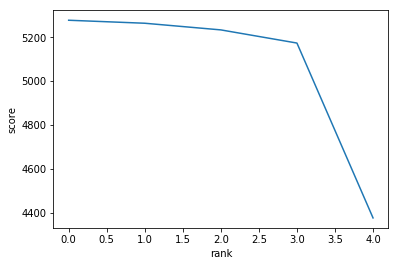

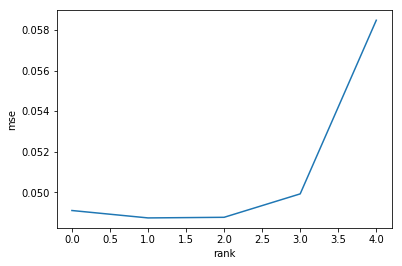

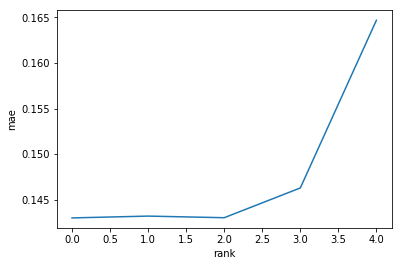

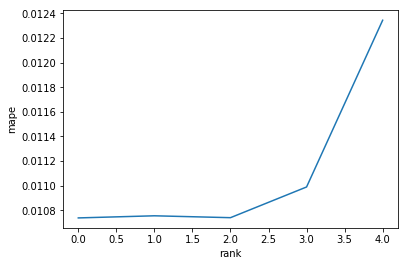

In [29]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

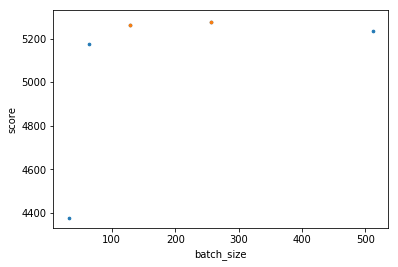

In [30]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=7)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

In [1]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['mae'][:2], s=7)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

NameError: name 'params_gsearch' is not defined

#### Hist

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


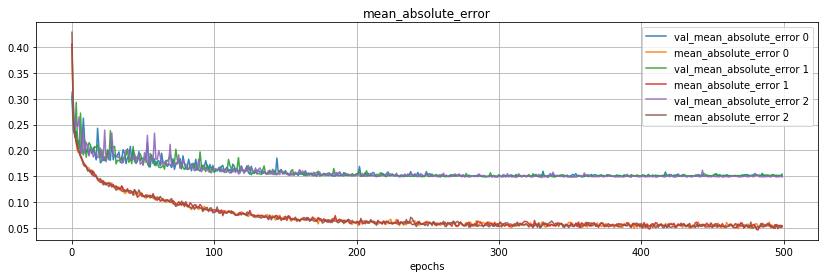

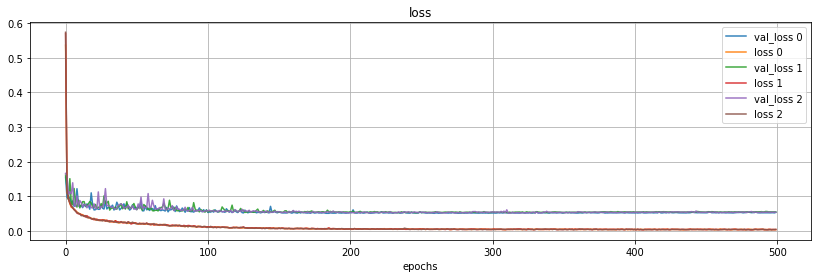

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


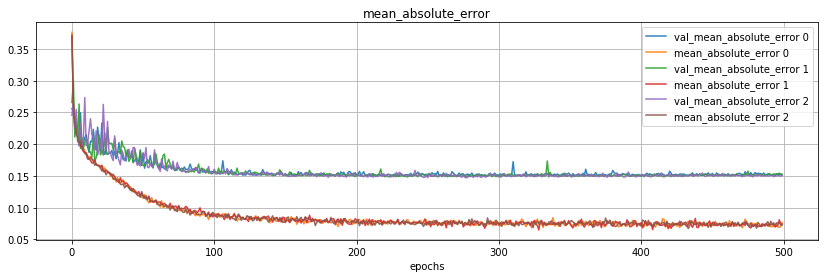

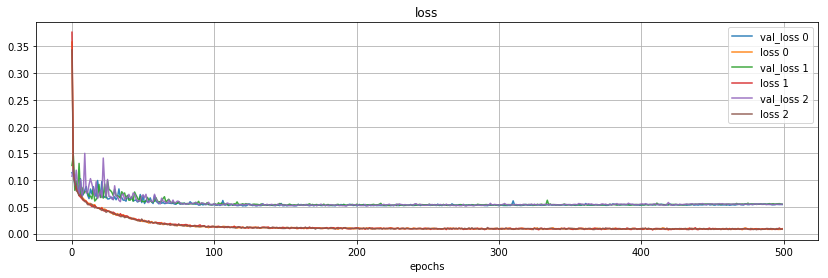

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


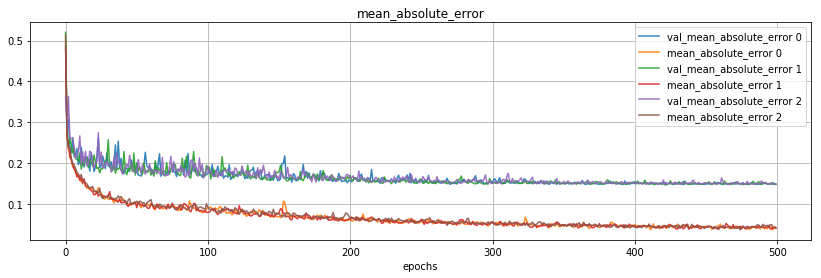

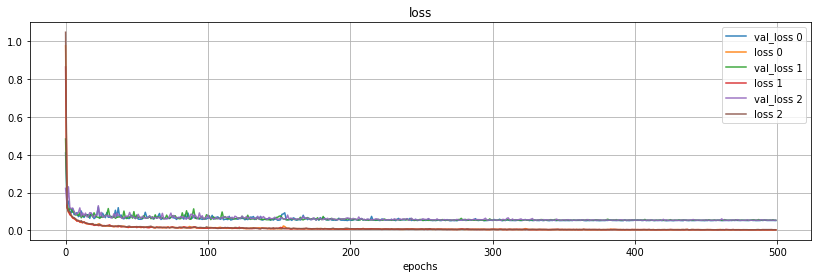

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


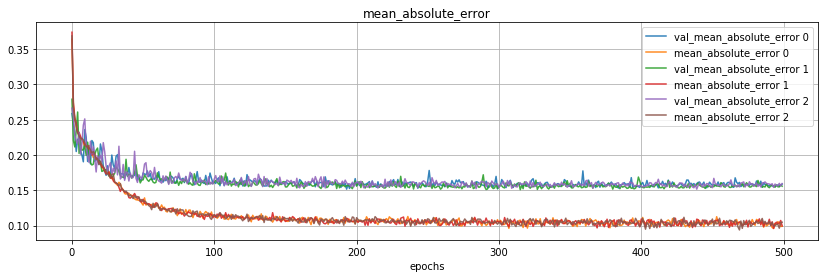

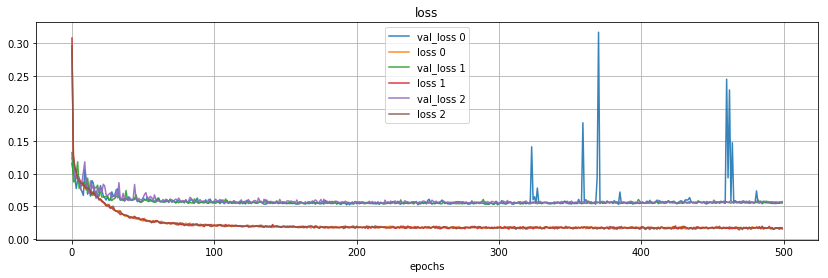

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


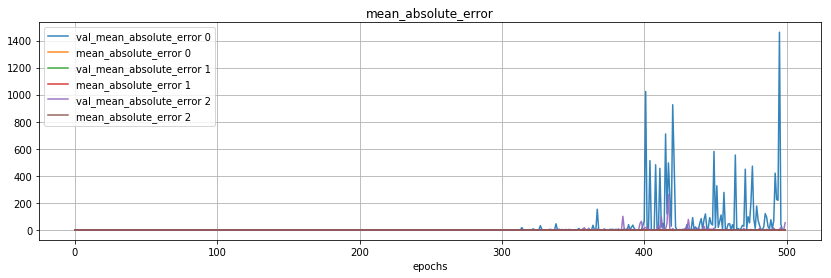

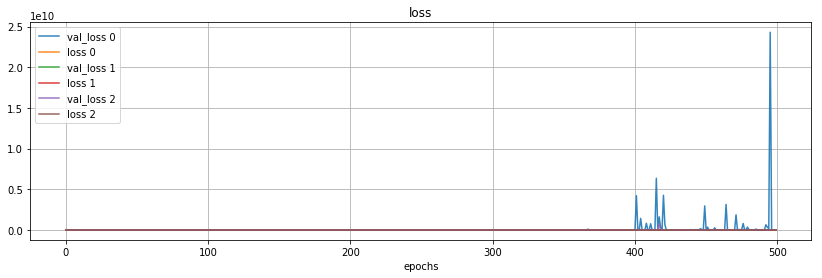

In [33]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


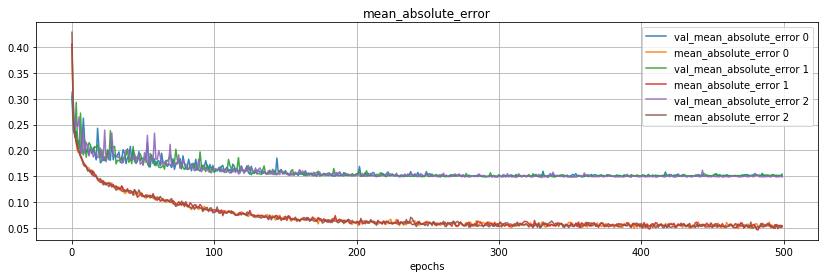

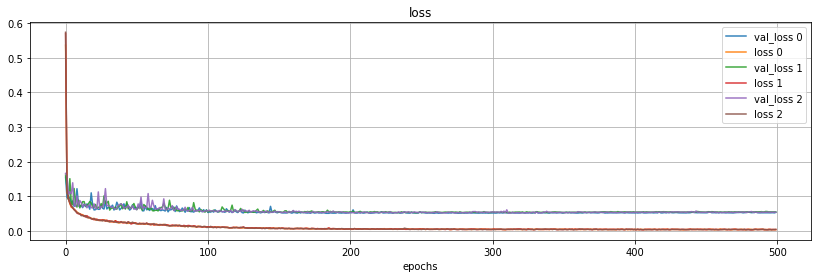

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


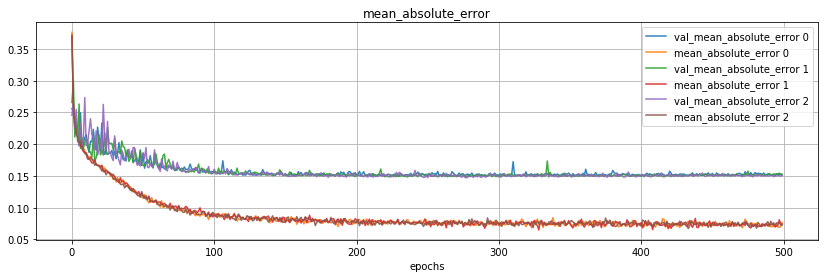

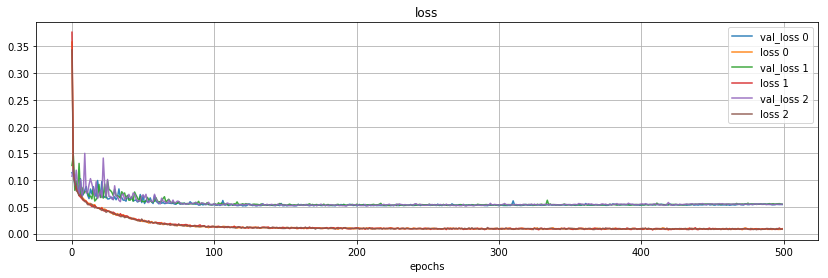

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


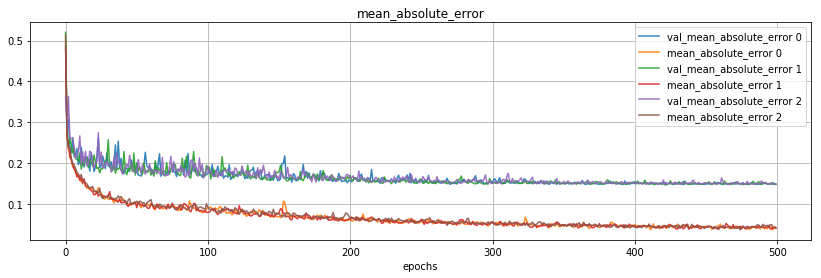

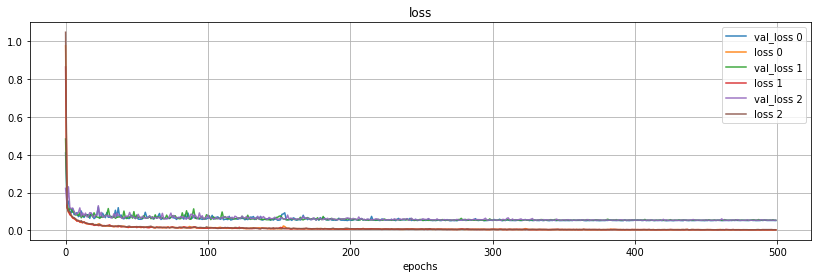

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


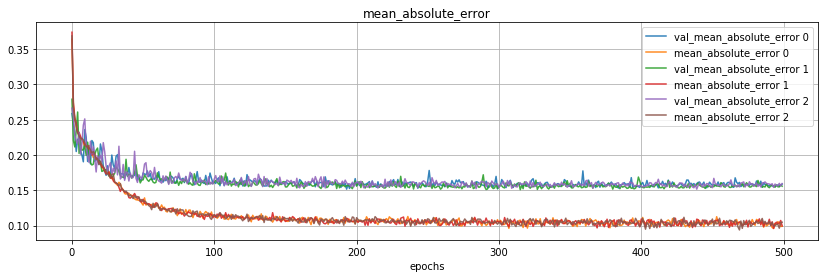

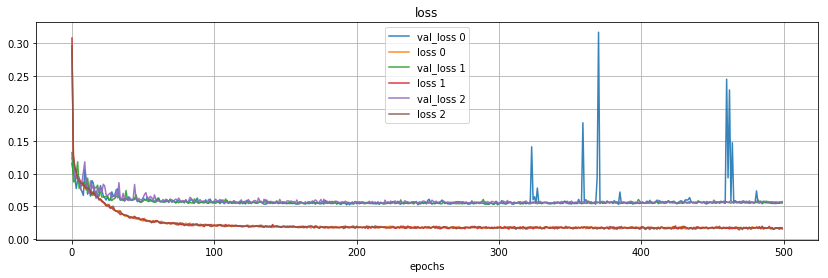

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


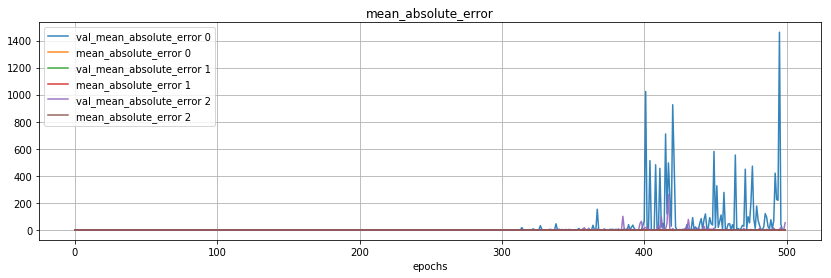

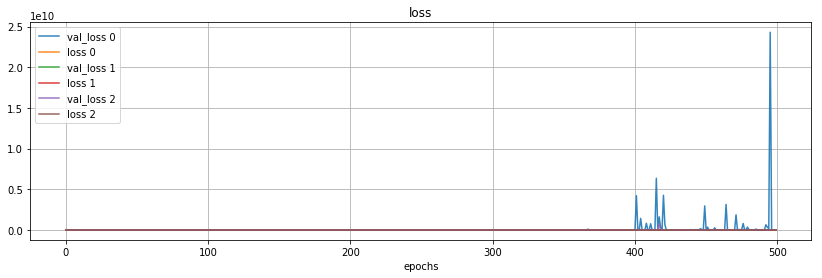

In [34]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


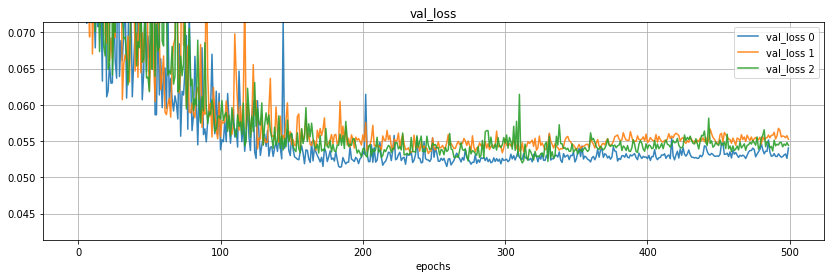

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


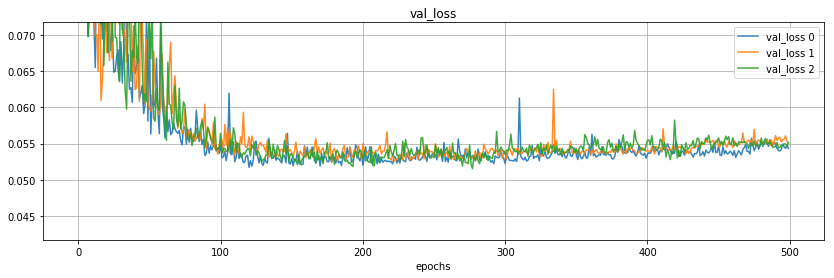

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


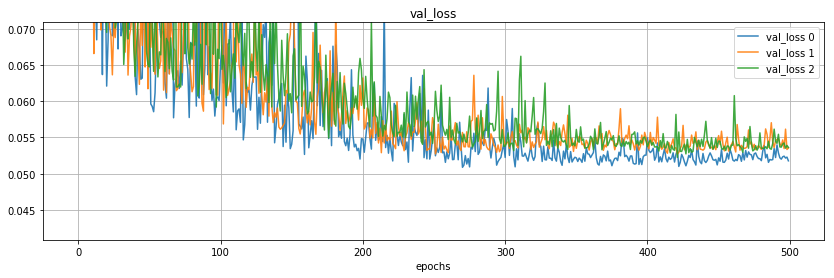

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


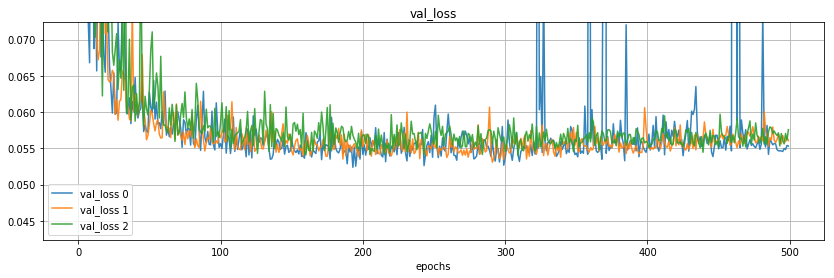

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


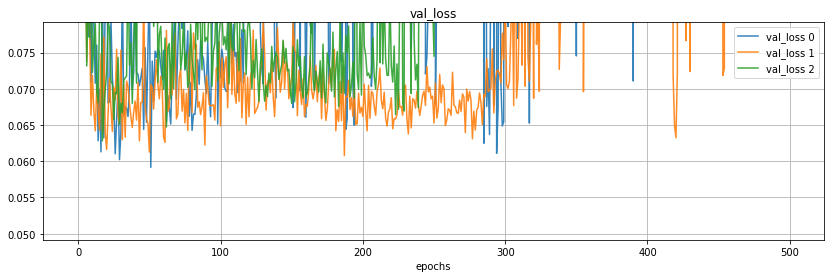

In [35]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


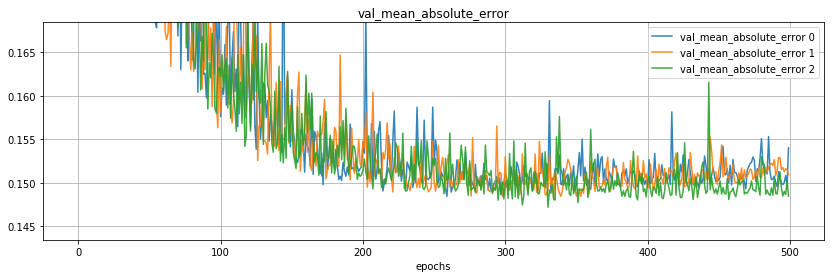

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


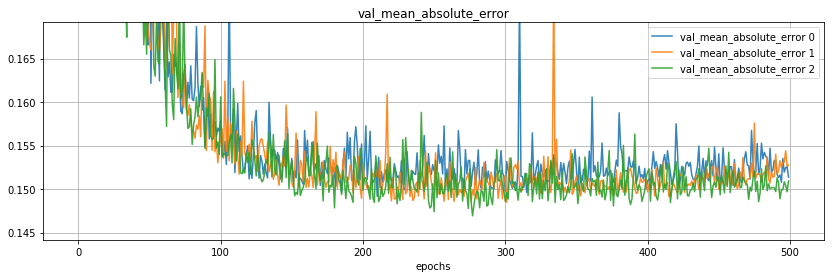

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


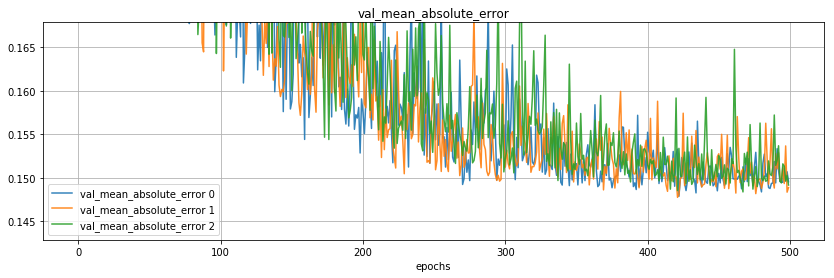

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


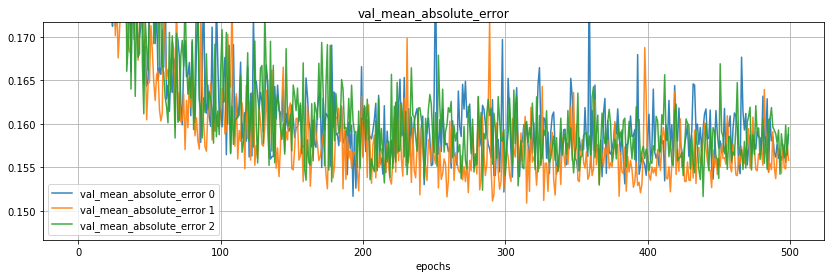

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


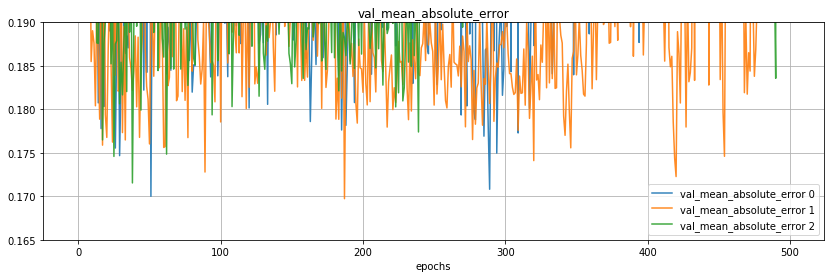

In [36]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


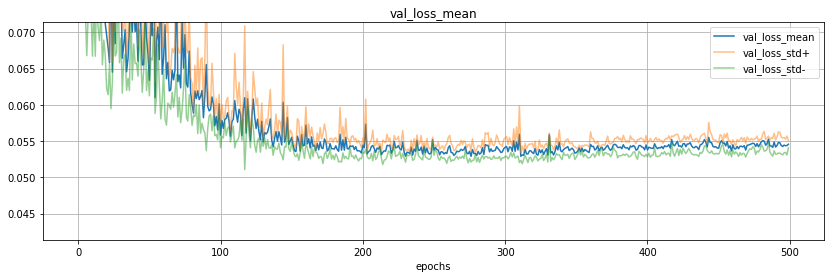

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


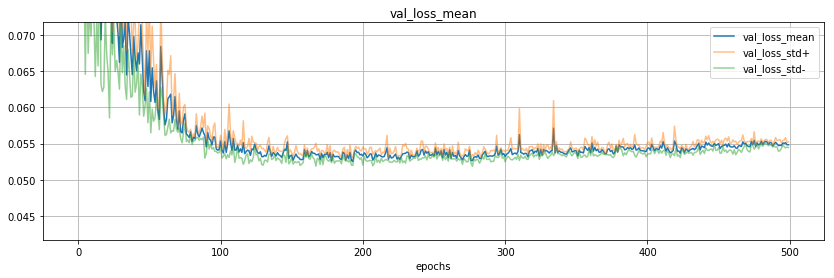

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


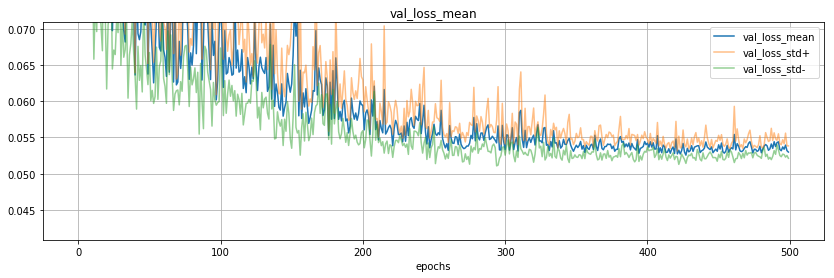

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


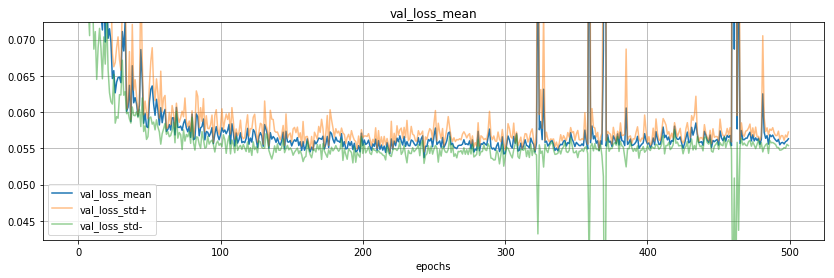

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


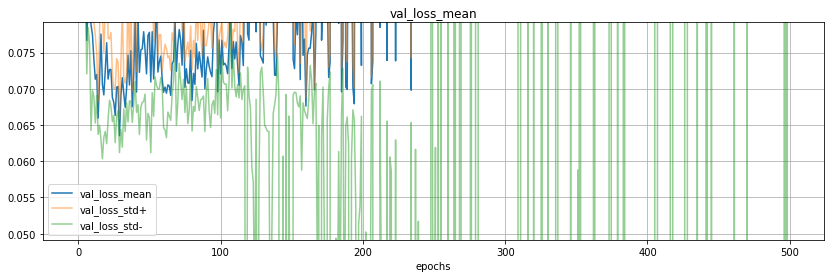

In [37]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                     min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 256, 'batch_norm': True}


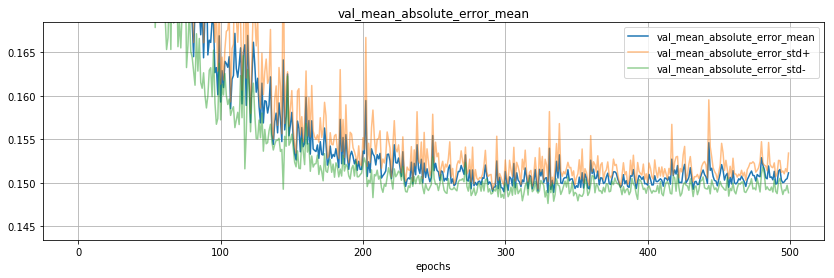

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 128, 'batch_norm': True}


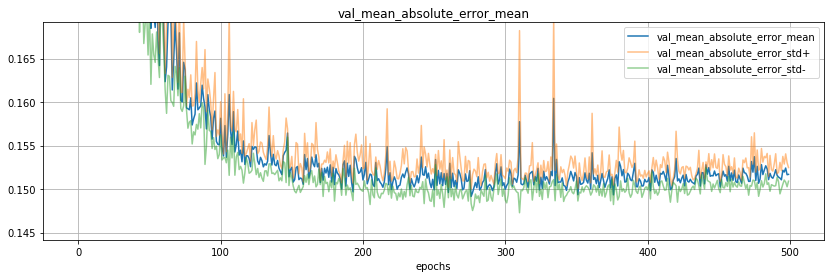

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 512, 'batch_norm': True}


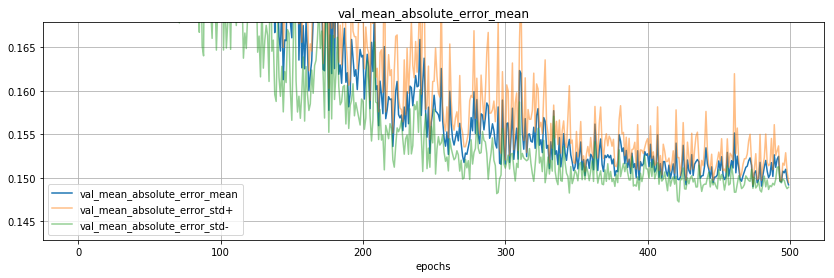

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 64, 'batch_norm': True}


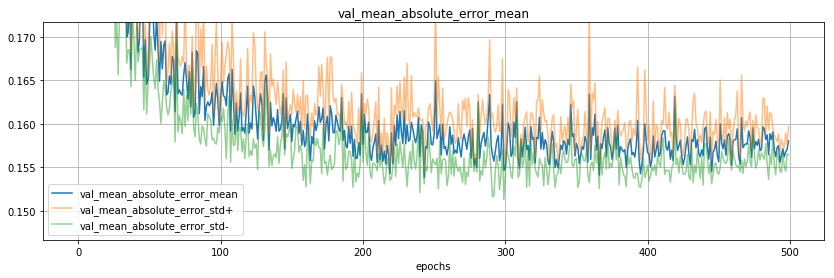

params: {'epochs': 500, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545), 'loss': 'mse', 'batch_size': 32, 'batch_norm': True}


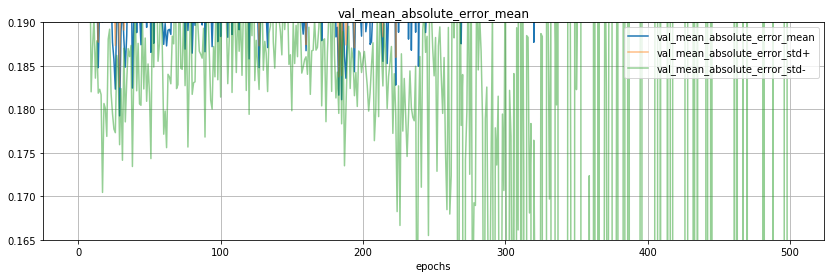

In [38]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                     min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

#### Mean scores

In [42]:
df_gsearch_results.check()

score       mse       mae      mape  batch_norm  batch_size  \
0  5277.516509  0.049098  0.143000  0.010739        True         256   
1  5263.848861  0.048733  0.143199  0.010756        True         128   
2  5233.515322  0.048764  0.143023  0.010741        True         512   
3  5173.512464  0.049919  0.146287  0.010990        True          64   
4  4376.315681  0.058480  0.164691  0.012343        True          32   

   best_iterations  epochs loss  mean_best_iterations  \
0  [260, 335, 331]     500  mse                   309   
1  [211, 302, 278]     500  mse                   264   
2  [423, 422, 468]     500  mse                   438   
3  [194, 316, 440]     500  mse                   317   
4    [52, 188, 39]     500  mse                    93   

                            n_neurons  \
0  (2180, 2180, 1090, 1090, 545, 545)   
1  (2180, 2180, 1090, 1090, 545, 545)   
2  (2180, 2180, 1090, 1090, 545, 545)   
3  (2180, 2180, 1090, 1090, 545, 545)   
4  (2180, 2180, 1090, 1090, 545, 545)   

                                             history  mean_mse_nn  \
0  [{'val_mean_absolute_error': [0.30353351488113...     0.054865   
1  [{'val_mean_absolute_error': [0.25625733444690...     0.053779   
2  [{'val_mean_absolute_error': [0.48807149739265...     0.052926   
3  [{'val_mean_absolute_error': [0.25883020129203...     0.055307   
4  [{'val_mean_absolute_error': [0.24439730746746...     0.073124   

   mean_mae_nn  std_mse_nn  std_mae_nn  
0     0.151156    0.002077    0.001204  
1     0.151825    0.000915    0.001797  
2     0.149959    0.000927    0.000332  
3     0.157520    0.000559    0.000323  
4     0.195092    0.006181    0.008367

shape = (5, 16)


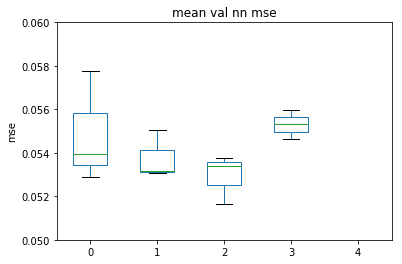

In [39]:
pd.DataFrame([
    [hist['val_loss'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.05, 0.06), title='mean val nn mse'); plt.ylabel('mse'); plt.show()

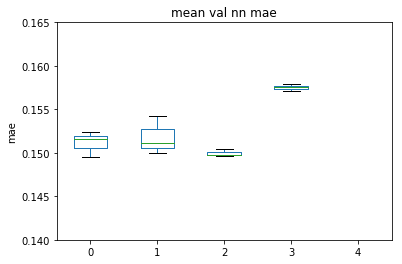

In [40]:
pd.DataFrame([
    [hist['val_mean_absolute_error'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.14, 0.165), title='mean val nn mae'); plt.ylabel('mae'); plt.show()

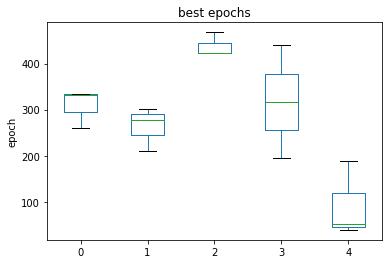

In [41]:
pd.DataFrame([
    row for row in df_gsearch_results['best_iterations']
]).T.plot.box(title='best epochs'); plt.ylabel('epoch'); plt.show()

In [43]:
exit()

E0706 12:00:02.851329 140172675516160 alias.py:221] Invalid alias: The name clear can't be aliased because it is another magic command.
E0706 12:00:02.852462 140172675516160 alias.py:221] Invalid alias: The name more can't be aliased because it is another magic command.
E0706 12:00:02.853154 140172675516160 alias.py:221] Invalid alias: The name less can't be aliased because it is another magic command.
E0706 12:00:02.854004 140172675516160 alias.py:221] Invalid alias: The name man can't be aliased because it is another magic command.


### Result